In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

**Methods and definitions.**

In [2]:
def my_pie(data, group, title, ax=None, figsize=None):
    data.groupby([group]).size().plot.pie(
        title=title, 
        ylabel='', 
        autopct=lambda p:'{:.1f}% ({:.0f})'.format(p, (p/100)*data.groupby([group]).size().sum()),
        figsize=figsize,
        ax=ax
    )

def my_bar(data, group, title, ax=None, figsize=None):
    ax_t = data.groupby([group]).size().plot.bar(
        title=title, 
        ylabel='count', 
        figsize=figsize,
        ax=ax
    )
    ax_t.bar_label(ax_t.containers[0])

def my_hist_with_qq(data, column, title, xlabel, figsize=(15, 6)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    data[column].plot.hist(title=title, ax=ax1)
    ax1.set_xlabel(xlabel)
    
    with mpl.rc_context():
        mpl.rc("figure", figsize=(3,3))
        sm.qqplot(data[column], line ='45', fit=True, ax=ax2)

def my_count(data, column, title, ax=None, order=None):
    fig, ax_t = plt.subplots()
    ax_t = sns.countplot(
        y = column, 
        data = data, 
        order = order, 
        ax=ax,
        palette='deep'
    )
    ax_t.bar_label(ax_t.containers[0])
    ax_t.set_title(title)

def my_box(data, columns, title, xlabel='count', ax=None, figsize=None):
    fig, ax_t = plt.subplots(figsize=figsize)
    ax_t = sns.boxplot(
        data=data[[x for x in data.columns if x in columns]],
        orient='h',
        ax=ax,
        palette='deep'
    ).set(xlabel=xlabel, title=title)

def my_box_xy(data, x, y, title, xlabel='count', ax=None, order=None):
    if(not ax):
        fig, ax_t = plt.subplots()
    sns.boxplot(
        data=data,
        orient='h',
        ax=ax,
        x=x,
        y=y,
        palette='deep',
        order=order
    ).set(xlabel=xlabel, title=title)
    
def my_dist(data, x, hue, title):
    sns.displot(
        data=data, 
        x=x, 
        hue=hue, 
        kind="kde",
    ).set(title=title)
    
def my_test(test, data, column, group, title):
    print(title)
    cols = [data[data[group] == x][column] for x in data[group].unique()]
    stat = test(*cols)
    print("{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))

    if(stat.pvalue < 0.05 and test == stats.kruskal):
        p_vals = []

        for comb in list(combinations(cols, 2)):
            stat = stats.mannwhitneyu(*comb)
            p_vals.append(stat.pvalue)

        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(data[group].unique(), 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')
        

def my_chi(data, group1, group2, merge_index=False, merge_cols=False):
    counts = data.groupby([group1, group2]).size().unstack().fillna(0)
    
    if(merge_index):
        for index in merge_index:
            for index2 in merge_index[index]:
                counts.loc[index] = counts.loc[index] + counts.loc[index2]
                counts = counts.drop(axis=0, index=[index2])
        
    if(merge_cols):
        for col in merge_cols:
            for col2 in merge_cols[col]:
                counts.loc[:, col] = counts.loc[:, col] + counts.loc[:, col2]
                counts = counts.drop(axis=1, columns=[col2])
                
    print(counts, end='\n\n')
    
    stat, p, d, exp = stats.chi2_contingency(counts)
    print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
    print('expected frequencies:')
    print(exp, end='\n\n')
    
    if(p < 0.05):
        p_vals = []

        for comb in list(combinations(counts.columns, 2)):
            new_df = counts[[comb[0], comb[1]]]
            chi2, p, dof, ex = stats.chi2_contingency(new_df)
            p_vals.append(p)
        with np.errstate(divide='ignore'):
            reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(counts.columns, 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')

def my_bar_grouped(data, column, group, title, hue_order=None, ax=None):
    plt.figure(tight_layout=True)
    ax_t = sns.barplot(
        data=data.groupby([column, group]).size().reset_index(), 
        y=0, 
        x=column, 
        hue=group,
        palette='deep',
        linewidth=2,
        hue_order = hue_order,
        ax=ax
    ).set(title=title, xlabel=column, ylabel='count')

def my_mean_plot(data, columns, group, title, label_x=None, label_y=None, order=None):
    if(not order):
        data.groupby([group]).mean().reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    else:
        data.groupby([group]).mean().loc[order].reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
def my_heatmap(data, columns):
    corr = data[columns].corr(method='spearman')
    sns.heatmap(corr, annot=True)
    
def multiple_tests(test, columns, labels):
    p_vals = []

    for comb in list(combinations(columns, 2)):
        stat = test(*comb)
        p_vals.append(stat.pvalue)

    if(test == stats.kruskal or test == stats.mannwhitneyu):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    if(test == stats.chi2_contingency):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

    print('Post-hoc testing:')
    print(list(combinations(labels, 2)))
    print(corrected_p_vals)
    print(reject_list, end='\n\n\n')
    
def my_test2(test, followup_test, columns, title, labels):
    print(title)
    stat = test(*columns)
    for i in range(len(columns)):
        print(labels[i] + ' mean: ' + str(columns[i].mean()))
        print(labels[i] + ' std: ' + str(columns[i].std()))
    print("\n{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))
    
    if(stat.pvalue < 0.05 and len(columns) > 2):
        multiple_tests(stats.mannwhitneyu, columns, labels)
    

attrak = {
    'PQ1': 'complicated - simple', 
    'PQ2': 'impractical - practical', 
    'PQ3': 'unpredictable - predictable', 
    'PQ4': 'confusing - clearly constructed', 
    'HQ1': 'tacky - stylish', 
    'HQ2': 'cheap - premium', 
    'HQ3': 'unimaginative - creative', 
    'HQ4': 'dull - captivating', 
    'ATT1': 'ugly - attractive', 
    'ATT2': 'bad - good',
    'PQ': 'All pragmatic qualities',
    'HQ': 'All hedonic qualities',
    'ATT': 'All attractiveness qualities'
}

open_text = {
    'company': 'Company\'s name',
    'purpose': 'Company\'s purpose',
    'purpose_token_count': 'Number of full meaning words in purpose',
    'purpose_word_count': 'Number of words in purpose question',
    'detail': 'Website\'s detail',
    'desc_eval_comp': 'Description complexity',
    'desc_eval_elem': 'Number of identified elements in description',
    'desc_eval_char': 'Number of identified characterists in description',
    'desc_eval_sum': 'Sum of identified characteristics and elements in description',
    'desc_token_count': 'Number of full meaning words in description',
    'desc_word_count': 'Number of words in description'
}

# Time - cognitive abilities relationship

**Load and merge data.**

In [3]:
results = pd.read_csv("../data/results.csv", index_col=0)
respondents = pd.read_csv("../data/respondents.csv", index_col=0)
respondents = respondents[respondents.status=='completed']
data = results.merge(respondents[
    ['respondent', 'interval', 'time_taken', 
     'vmt_levels', 'vmt_levels_group',
     'vmt_click_speed', 'vmt_click_speed_group', 
     'vmt_press_len', 'vmt_press_len_group',
     'pst_levels', 'pst_levels_group',
     'pst_levels_correct', 'pst_levels_correct_group',
     'pst_mistakes', 'pst_mistakes_group',
     'pst_press_speed', 
     'age', 'gender', 'education', 'web_browsing', 'web_skill']
], on=['respondent', 'interval'], how='outer')

**Calculate groups**

In [4]:
data['vmt_interval'] = ''
for index, row in data.iterrows():
    data.loc[index, 'vmt_interval'] = row.vmt_levels_group + '_' + row.interval

In [5]:
data['pst_interval'] = ''
for index, row in data.iterrows():
    data.loc[index, 'pst_interval'] = row.pst_levels_correct_group + '_' + row.interval

In [6]:
fixed_data = data[(data.interval != '2s') | (data.interval == '2s') & (data.respondent != 50)]

## VMT levels

**Mean.**

In [7]:
data[['task', 'vmt_levels_group'] + list(attrak.keys())].groupby(['task', 'vmt_levels_group']).mean()

PQ1       PQ2       PQ3       PQ4       HQ1  \
task vmt_levels_group                                                     
1    high              6.233333  5.900000  5.433333  6.133333  5.200000   
     low               5.724138  5.655172  5.275862  5.482759  5.034483   
     med               5.639344  5.442623  5.098361  5.672131  5.049180   
2    high              5.433333  5.433333  4.866667  5.166667  4.666667   
     low               4.896552  5.137931  4.655172  4.689655  4.758621   
     med               5.213115  5.245902  5.032787  5.196721  4.524590   
3    high              4.833333  5.133333  4.566667  4.933333  4.666667   
     low               5.000000  5.241379  4.965517  5.206897  4.896552   
     med               4.786885  5.147541  4.819672  5.131148  4.934426   
4    high              4.733333  5.433333  5.266667  5.233333  4.033333   
     low               5.068966  5.827586  5.551724  5.517241  4.551724   
     med               4.590164  5.409836  5.295082  4.918033  4.213115   
5    high              4.200000  4.433333  4.433333  4.133333  3.166667   
     low               3.620690  4.275862  3.896552  3.241379  3.241379   
     med               4.196721  4.426230  4.409836  4.327869  3.540984   
6    high              3.400000  4.366667  4.400000  4.166667  4.033333   
     low               2.827586  4.034483  4.517241  3.551724  3.620690   
     med               2.918033  3.688525  4.000000  3.344262  3.590164   

                            HQ2       HQ3       HQ4      ATT1      ATT2  \
task vmt_levels_group                                                     
1    high              4.833333  4.566667  4.733333  5.600000  5.733333   
     low               4.586207  4.379310  4.206897  5.172414  5.310345   
     med               4.639344  3.934426  4.163934  5.065574  5.032787   
2    high              4.433333  4.000000  4.366667  5.000000  4.833333   
     low               4.758621  4.586207  4.689655  5.034483  4.862069   
     med               4.311475  4.032787  4.032787  4.819672  4.688525   
3    high              4.700000  4.600000  4.533333  4.966667  4.933333   
     low               5.137931  4.827586  4.896552  5.275862  5.413793   
     med               4.704918  4.409836  4.721311  5.147541  4.983607   
4    high              3.633333  3.733333  3.866667  4.033333  4.666667   
     low               3.931034  3.862069  4.241379  4.724138  5.241379   
     med               3.868852  3.803279  4.081967  4.295082  4.819672   
5    high              3.133333  3.400000  4.000000  3.500000  3.733333   
     low               2.965517  3.482759  3.482759  3.448276  3.758621   
     med               3.229508  3.655738  3.934426  3.836066  4.032787   
6    high              4.166667  3.266667  3.300000  3.500000  3.833333   
     low               3.862069  3.172414  3.034483  2.758621  3.827586   
     med               3.278689  2.786885  2.950820  3.000000  3.393443   

                             PQ        HQ       ATT  
task vmt_levels_group                                
1    high              5.925000  4.833333  5.666667  
     low               5.534483  4.551724  5.241379  
     med               5.463115  4.446721  5.049180  
2    high              5.225000  4.366667  4.916667  
     low               4.844828  4.698276  4.948276  
     med               5.172131  4.225410  4.754098  
3    high              4.866667  4.625000  4.950000  
     low               5.103448  4.939655  5.344828  
     med               4.971311  4.692623  5.065574  
4    high              5.166667  3.816667  4.350000  
     low               5.491379  4.146552  4.982759  
     med               5.053279  3.991803  4.557377  
5    high              4.300000  3.425000  3.616667  
     low               3.758621  3.293103  3.603448  
     med               4.340164  3.590164  3.934426  
6    high              4.083333  3.691667  3.666667  
     low               3.732759  3.422414  3.293103  


In [8]:
data[['task', 'vmt_levels_group'] + list(open_text.keys())].groupby(['task', 'vmt_levels_group']).mean()

company   purpose  purpose_token_count  \
task vmt_levels_group                                            
1    high              0.966667  1.000000             2.500000   
     low               0.931034  0.965517             2.448276   
     med               0.967213  0.950820             2.245902   
2    high              0.866667  0.916667             3.566667   
     low               0.862069  0.758621             2.758621   
     med               0.926230  0.811475             2.540984   
3    high              0.900000  0.900000             2.766667   
     low               0.862069  0.896552             3.137931   
     med               0.877049  0.877049             3.016393   
4    high              1.000000  1.000000             2.566667   
     low               0.982759  1.000000             2.862069   
     med               0.967213  0.983607             2.540984   
5    high              0.933333  0.850000             2.600000   
     low               0.931034  0.603448             2.172414   
     med               0.934426  0.754098             2.229508   
6    high              0.916667  0.700000             3.333333   
     low               0.931034  0.724138             2.448276   
     med               0.926230  0.606557             2.508197   

                       purpose_word_count    detail  desc_eval_comp  \
task vmt_levels_group                                                 
1    high                        3.833333  0.300000        1.566667   
     low                         3.482759  0.172414        0.827586   
     med                         3.262295  0.163934        0.950820   
2    high                        5.300000  0.533333        1.166667   
     low                         3.586207  0.551724        0.724138   
     med                         3.540984  0.622951        0.852459   
3    high                        3.866667  0.133333        1.366667   
     low                         4.275862  0.241379        0.758621   
     med                         4.442623  0.172131        0.901639   
4    high                        4.300000  0.366667        1.566667   
     low                         4.655172  0.189655        0.689655   
     med                         3.573770  0.295082        0.852459   
5    high                        5.033333  0.333333        1.066667   
     low                         4.448276  0.327586        0.551724   
     med                         4.327869  0.286885        0.672131   
6    high                        5.600000  0.216667        1.266667   
     low                         4.379310  0.103448        0.620690   
     med                         4.786885  0.049180        0.770492   

                       desc_eval_elem  desc_eval_char  desc_eval_sum  \
task vmt_levels_group                                                  
1    high                    2.166667        0.700000       2.866667   
     low                     1.206897        0.620690       1.827586   
     med                     1.311475        0.508197       1.819672   
2    high                    1.966667        0.500000       2.466667   
     low                     1.448276        0.310345       1.758621   
     med                     1.442623        0.459016       1.901639   
3    high                    2.466667        0.266667       2.733333   
     low                     1.655172        0.103448       1.758621   
     med                     1.918033        0.245902       2.163934   
4    high                    2.266667        0.466667       2.733333   
     low                     1.344828        0.379310       1.724138   
     med                     1.508197        0.278689       1.786885   
5    high                    1.533333        0.733333       2.266667   
     low                     0.931034        0.413793       1.344828   
     med                     1.196721        0.426230       1.622951   
6    high                    1.800000        0.733333     

**Median.**

In [9]:
data[['task', 'vmt_levels_group'] + list(attrak.keys())].groupby(['task', 'vmt_levels_group']).median()

PQ1  PQ2  PQ3  PQ4  HQ1  HQ2  HQ3  HQ4  ATT1  ATT2  \
task vmt_levels_group                                                       
1    high              6.0  6.0  5.0  6.0  5.0  5.0  5.0  5.0   6.0   6.0   
     low               6.0  6.0  5.0  6.0  5.0  5.0  4.0  4.0   5.0   6.0   
     med               6.0  6.0  5.0  6.0  5.0  5.0  4.0  4.0   5.0   5.0   
2    high              6.0  5.5  5.0  5.0  5.0  4.0  4.0  4.0   5.0   5.0   
     low               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   5.0   5.0   
     med               5.0  5.0  5.0  5.0  5.0  4.0  4.0  4.0   5.0   5.0   
3    high              5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   5.0   5.0   
     low               5.0  5.0  5.0  6.0  5.0  5.0  5.0  5.0   5.0   5.0   
     med               5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0   5.0   5.0   
4    high              5.0  6.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0   
     low               5.0  6.0  6.0  6.0  4.0  4.0  4.0  4.0   5.0   5.0   
     med               4.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0   
5    high              4.0  5.0  5.0  4.0  3.0  3.0  3.0  4.0   3.0   3.5   
     low               3.0  4.0  4.0  3.0  3.0  3.0  3.0  3.0   3.0   4.0   
     med               4.0  5.0  4.0  5.0  4.0  3.0  4.0  4.0   4.0   4.0   
6    high              3.0  4.5  4.5  4.0  4.0  4.0  3.0  3.0   3.0   4.0   
     low               3.0  4.0  5.0  3.0  4.0  4.0  3.0  3.0   2.0   4.0   
     med               3.0  4.0  4.0  3.0  4.0  3.0  3.0  3.0   3.0   3.0   

                          PQ    HQ   ATT  
task vmt_levels_group                     
1    high              6.000  5.00  6.00  
     low               5.500  4.50  5.50  
     med               5.500  4.50  5.00  
2    high              5.250  4.25  5.00  
     low               5.250  5.00  5.00  
     med               5.250  4.25  5.00  
3    high              5.125  4.75  5.00  
     low               5.250  5.00  5.50  
     med               5.000  4.75  5.00  
4    high              5.250  3.75  4.50  
     low               5.500  4.00  5.00  
     med               5.000  4.00  4.50  
5    high              4.500  3.25  3.50  
     low               3.500  3.00  3.50  
     med               4.500  3.75  4.00  
6    high              4.250  3.50  3.75  
     low               3.750  3.25  3.00  
     med               3.500  3.25  3.00

In [10]:
data[['task', 'vmt_levels_group'] + list(open_text.keys())].groupby(['task', 'vmt_levels_group']).median()

company  purpose  purpose_token_count  \
task vmt_levels_group                                          
1    high                  1.0      1.0                  2.0   
     low                   1.0      1.0                  2.0   
     med                   1.0      1.0                  2.0   
2    high                  1.0      1.0                  3.0   
     low                   1.0      1.0                  3.0   
     med                   1.0      1.0                  2.0   
3    high                  1.0      1.0                  2.0   
     low                   1.0      1.0                  3.0   
     med                   1.0      1.0                  3.0   
4    high                  1.0      1.0                  2.0   
     low                   1.0      1.0                  2.0   
     med                   1.0      1.0                  2.0   
5    high                  1.0      1.0                  2.0   
     low                   1.0      1.0                  2.0   
     med                   1.0      1.0                  2.0   
6    high                  1.0      1.0                  3.0   
     low                   1.0      1.0                  2.0   
     med                   1.0      0.5                  2.0   

                       purpose_word_count  detail  desc_eval_comp  \
task vmt_levels_group                                               
1    high                             2.0     0.0             1.0   
     low                              3.0     0.0             1.0   
     med                              2.0     0.0             1.0   
2    high                             4.0     1.0             1.0   
     low                              3.0     1.0             1.0   
     med                              3.0     1.0             1.0   
3    high                             3.5     0.0             1.0   
     low                              3.0     0.0             1.0   
     med                              3.0     0.0             1.0   
4    high                             3.0     0.0             1.0   
     low                              3.0     0.0             1.0   
     med                              3.0     0.0             1.0   
5    high                             4.0     0.0             1.0   
     low                              2.0     0.0             0.0   
     med                              2.0     0.0             1.0   
6    high                             5.0     0.0             1.0   
     low                              3.0     0.0             1.0   
     med                              3.0     0.0             1.0   

                       desc_eval_elem  desc_eval_char  desc_eval_sum  \
task vmt_levels_group                                                  
1    high                         2.0             0.5            3.0   
     low                          1.0             0.0            2.0   
     med                          1.0             0.0            2.0   
2    high                         2.0             0.0            3.0   
     low                          1.0             0.0            1.0   
     med                          1.0             0.0            2.0   
3    high                         2.0             0.0            3.0   
     low                          2.0             0.0            2.0   
     med                          2.0             0.0            2.0   
4    high                         2.0             0.0            3.0   
     low                          1.0             0.0            2.0   
     med                          1.0             0.0            2.0   
5    high                         1.0             1.0            2.0   
     low                          1.0             0.0            1.0   
     med                          1.0             0.0            2.0   
6    high                         2.0             0.5            3.0   
     low                          1.0             0.0            

**Std.**

In [11]:
data[['task', 'vmt_levels_group'] + list(attrak.keys())].groupby(['task', 'vmt_levels_group']).std()

PQ1       PQ2       PQ3       PQ4       HQ1  \
task vmt_levels_group                                                     
1    high              0.773854  0.884736  0.727932  1.008014  1.030567   
     low               1.360057  1.009804  1.192133  1.121883  1.322410   
     med               1.033325  0.975100  1.075561  1.028288  1.116934   
2    high              1.135124  0.897634  1.357821  1.366681  1.028334   
     low               1.472239  1.552053  1.653478  1.794902  1.503690   
     med               0.933002  0.906564  0.965526  1.122789  0.941746   
3    high              1.261727  1.332183  1.250747  1.552158  1.470007   
     low               1.362770  1.214648  0.905647  1.346406  1.144703   
     med               1.050631  1.123033  1.087937  1.189894  1.062526   
4    high              1.460593  1.250747  1.412587  1.194335  1.033352   
     low               1.412471  1.311187  1.182800  1.121883  1.020721   
     med               1.346317  1.022693  1.115710  1.201320  0.877777   
5    high              1.349329  1.222866  0.897634  1.357821  1.315251   
     low               1.760961  1.485563  1.447777  1.661651  1.327058   
     med               1.458534  1.499545  1.382956  1.660535  1.409181   
6    high              1.631585  1.542129  1.404426  1.641768  1.188547   
     low               1.627201  1.822141  1.703372  1.804483  1.049278   
     med               1.508808  1.258848  1.290994  1.515313  0.972575   

                            HQ2       HQ3       HQ4      ATT1      ATT2  \
task vmt_levels_group                                                     
1    high              1.053183  1.072648  1.436791  1.275769  1.112107   
     low               1.376259  1.424625  1.423760  1.364576  1.105294   
     med               1.252102  1.276308  1.227196  0.997812  1.015992   
2    high              1.278019  1.114172  1.188547  1.203443  1.147211   
     low               1.527256  1.637010  1.416824  1.451176  1.597412   
     med               1.103645  0.999453  1.048288  0.991769  1.073017   
3    high              1.342925  1.354431  1.407696  1.473521  1.229896   
     low               1.025536  1.255530  1.012240  1.098588  1.052794   
     med               1.022159  1.174408  1.082145  1.046201  1.008163   
4    high              1.245221  1.229896  1.407696  1.217214  1.061337   
     low               1.279817  1.407230  1.184880  1.250616  1.243703   
     med               0.956999  0.980130  1.099925  1.054265  0.922103   
5    high              1.306043  1.248447  1.114172  1.525643  1.257620   
     low               0.981353  1.271127  1.639266  1.660168  1.353703   
     med               1.334084  1.459283  1.327515  1.496444  1.471589   
6    high              1.019917  1.080655  1.149213  1.358244  1.288767   
     low               1.156477  1.582696  1.401090  1.299867  1.390503   
     med               1.066633  1.141852  1.175106  1.154701  1.144242   

                             PQ        HQ       ATT  
task vmt_levels_group                                
1    high              0.666792  0.994236  1.147211  
     low               0.900704  1.227256  1.138770  
     med               0.850044  1.058807  0.902335  
2    high              0.992102  1.012281  1.017801  
     low               1.397405  1.421109  1.490115  
     med               0.789964  0.854772  0.942616  
3    high              1.076259  1.210140  1.268654  
     low               0.985423  0.955845  0.936401  
     med               0.914123  0.962195  0.941963  
4    high              1.055228  1.070637  1.043452  
     low               1.059571  1.082567  1.129813  
     med               0.920954  0.815178  0.876063  
5    high              0.985673  1.100842  1.277682  
     low               1.397515  1.114172  1.416606  
     med               1.301468  1.293439  1.412667  
6    high              1.287093  0.927741  1.234094  
     low               1.440689  1.033163  1.228510  


In [12]:
data[['task', 'vmt_levels_group'] + list(open_text.keys())].groupby(['task', 'vmt_levels_group']).std()

company   purpose  purpose_token_count  \
task vmt_levels_group                                            
1    high              0.182574  0.000000             1.432384   
     low               0.257881  0.185695             1.351882   
     med               0.179556  0.218039             1.598497   
2    high              0.319842  0.265334             2.269488   
     low               0.350931  0.435494             1.479748   
     med               0.238678  0.389058             1.669069   
3    high              0.275431  0.305129             1.774986   
     low               0.324493  0.309934             1.903458   
     med               0.311659  0.311659             1.875205   
4    high              0.000000  0.000000             1.406471   
     low               0.092848  0.000000             1.995068   
     med               0.179556  0.128037             1.361051   
5    high              0.217086  0.351107             1.922642   
     low               0.220557  0.470169             1.983305   
     med               0.232297  0.414558             2.578071   
6    high              0.230567  0.361987             1.787569   
     low               0.257881  0.413742             1.638514   
     med               0.255540  0.377655             2.262911   

                       purpose_word_count    detail  desc_eval_comp  \
task vmt_levels_group                                                 
1    high                        2.948797  0.466092        1.135124   
     low                         2.443953  0.384426        0.804850   
     med                         3.380836  0.373288        0.864605   
2    high                        4.829150  0.507416        0.985527   
     low                         2.442441  0.488160        0.840771   
     med                         2.686843  0.480067        0.771061   
3    high                        2.968029  0.345746        0.889918   
     low                         3.336985  0.435494        0.739458   
     med                         4.283786  0.375114        0.789618   
4    high                        4.900035  0.490133        1.072648   
     low                         4.194178  0.387616        0.806379   
     med                         2.584950  0.450713        0.749134   
5    high                        4.181101  0.461133        0.944433   
     low                         5.207043  0.448726        0.736120   
     med                         7.809655  0.451470        0.676297   
6    high                        3.783813  0.386927        1.014833   
     low                         3.437335  0.309934        0.727706   
     med                         6.115867  0.218039        0.761434   

                       desc_eval_elem  desc_eval_char  desc_eval_sum  \
task vmt_levels_group                                                  
1    high                    1.315251        0.876907       1.676065   
     low                     0.977581        0.727706       1.136064   
     med                     0.885833        0.721641       1.072508   
2    high                    1.217214        0.629724       1.407696   
     low                     1.270158        0.541390       1.214648   
     med                     0.940294        0.672651       1.121085   
3    high                    1.195778        0.520830       1.337350   
     low                     1.203443        0.409253       1.154345   
     med                     1.187365        0.471018       1.306144   
4    high                    1.337350        0.628810       1.460593   
     low                     1.173391        0.561490       1.250616   
     med                     1.104882        0.635902       1.112276   
5    high                    1.357821        0.691492       1.412587   
     low                     0.997534        0.568032       1.173391   
     med                     1.194706        0.561516       1.267069   
6    high                    1.323527        0.827682     

**Plots**

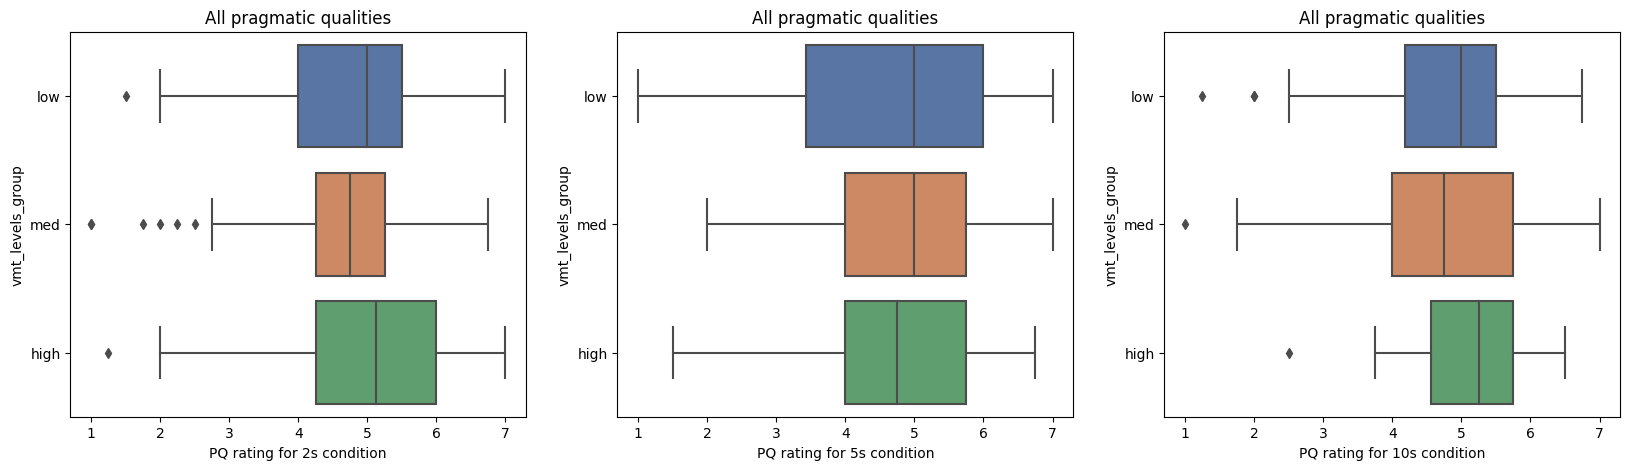

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'PQ', 'vmt_levels_group', attrak['PQ'], 'PQ rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'PQ', 'vmt_levels_group', attrak['PQ'], 'PQ rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'PQ', 'vmt_levels_group', attrak['PQ'], 'PQ rating for 10s condition', ax3, order=['low', 'med', 'high'])

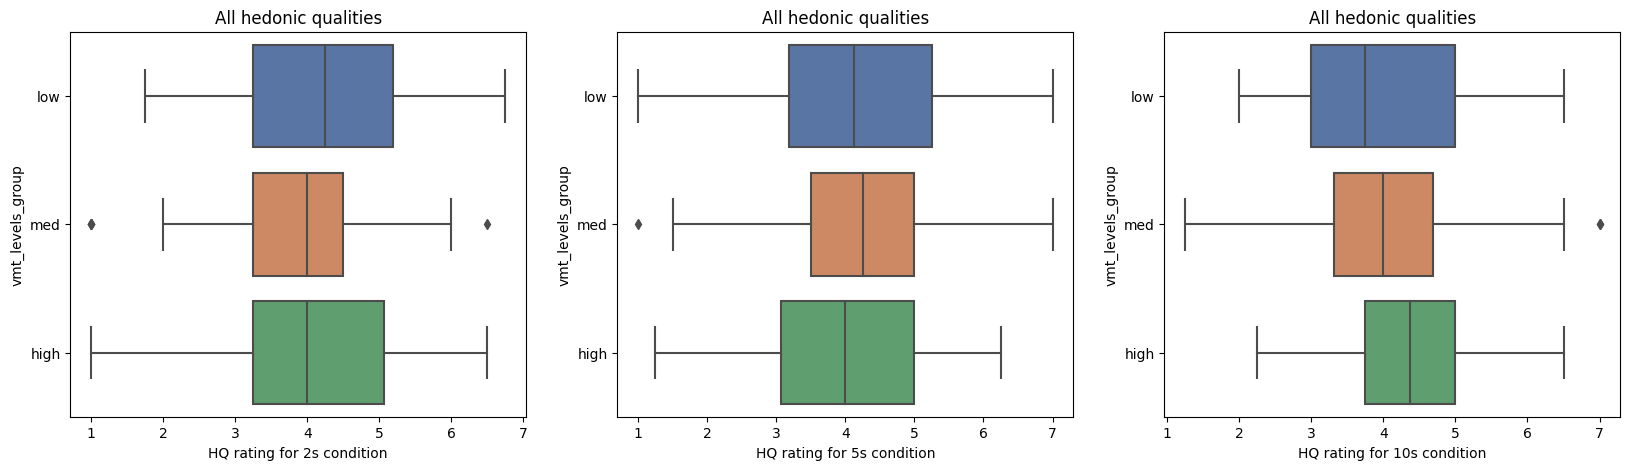

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'HQ', 'vmt_levels_group', attrak['HQ'], 'HQ rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'HQ', 'vmt_levels_group', attrak['HQ'], 'HQ rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'HQ', 'vmt_levels_group', attrak['HQ'], 'HQ rating for 10s condition', ax3, order=['low', 'med', 'high'])

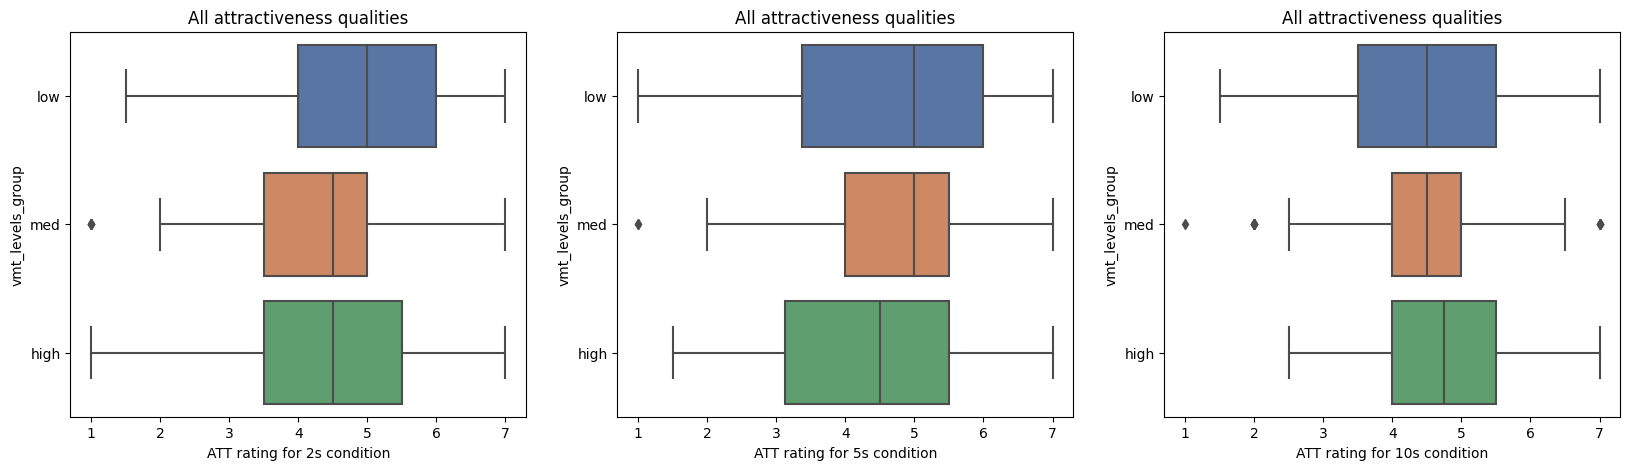

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'ATT', 'vmt_levels_group', attrak['ATT'], 'ATT rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'ATT', 'vmt_levels_group', attrak['ATT'], 'ATT rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'ATT', 'vmt_levels_group', attrak['ATT'], 'ATT rating for 10s condition', ax3, order=['low', 'med', 'high'])

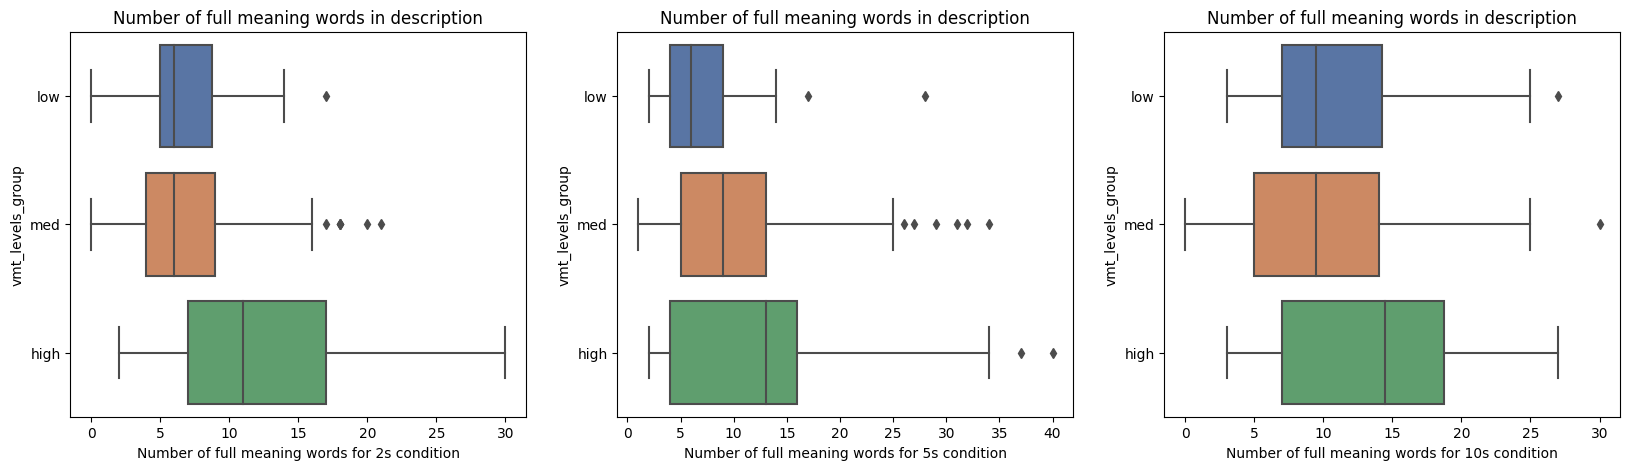

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'desc_token_count', 'vmt_levels_group', open_text['desc_token_count'], 'Number of full meaning words for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'desc_token_count', 'vmt_levels_group', open_text['desc_token_count'], 'Number of full meaning words for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'desc_token_count', 'vmt_levels_group', open_text['desc_token_count'], 'Number of full meaning words for 10s condition', ax3, order=['low', 'med', 'high'])

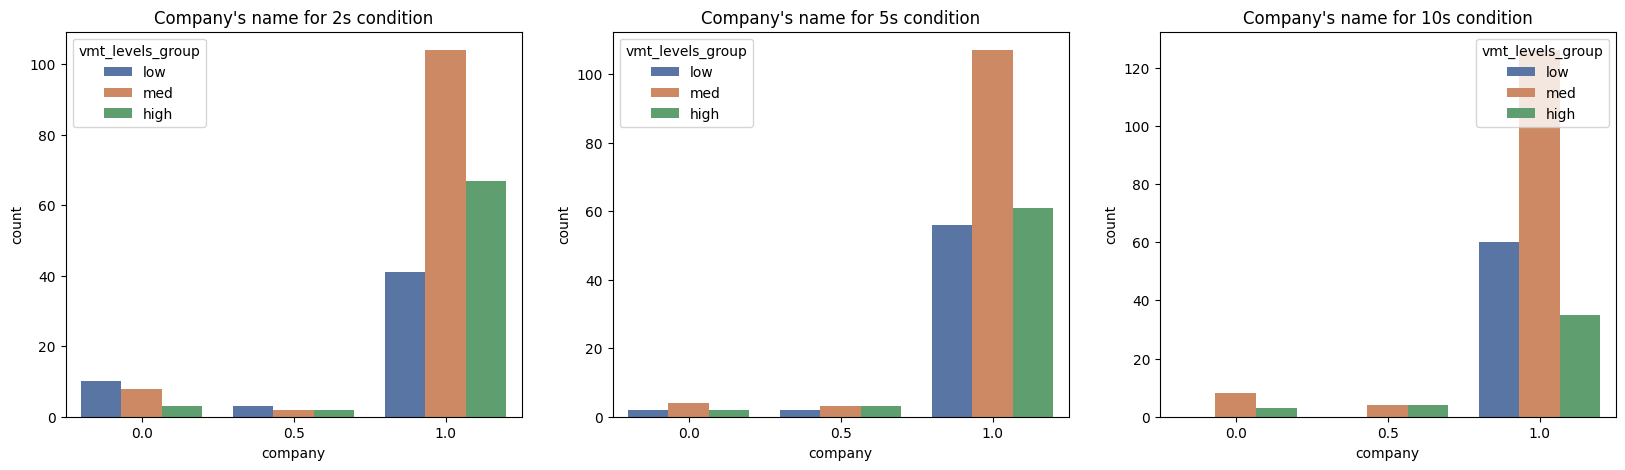

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

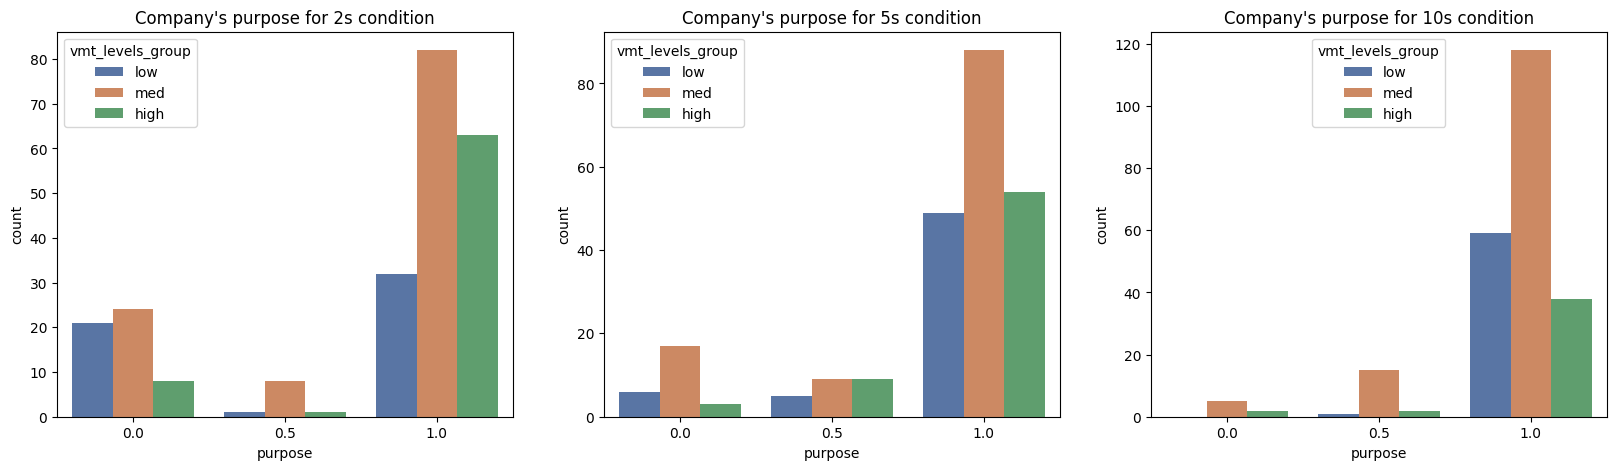

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

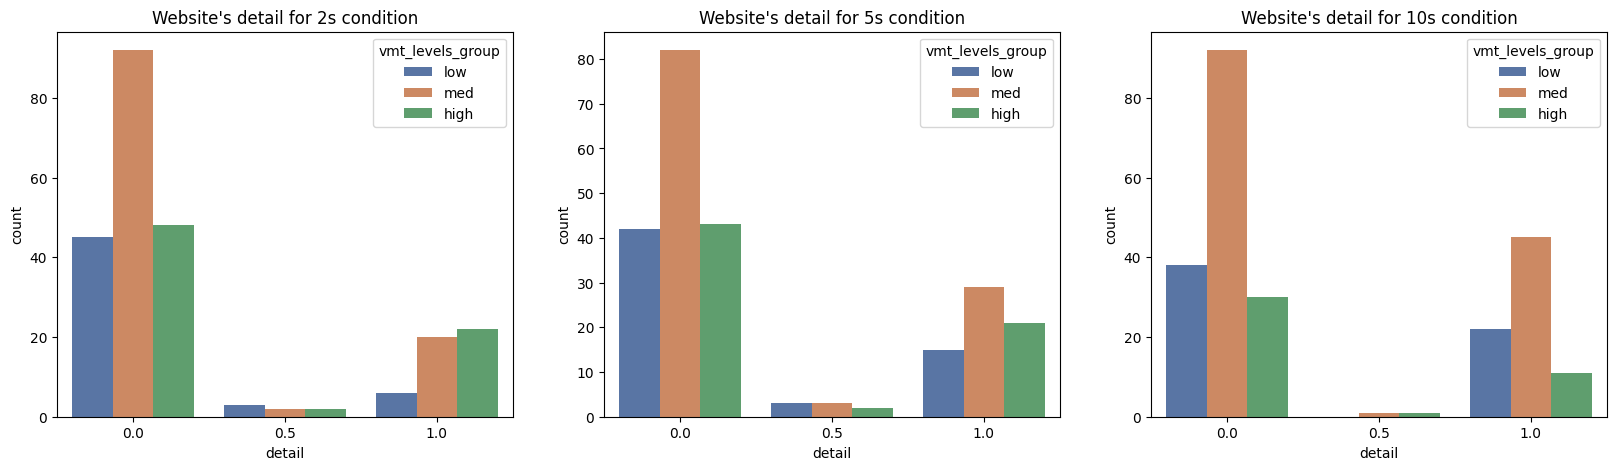

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

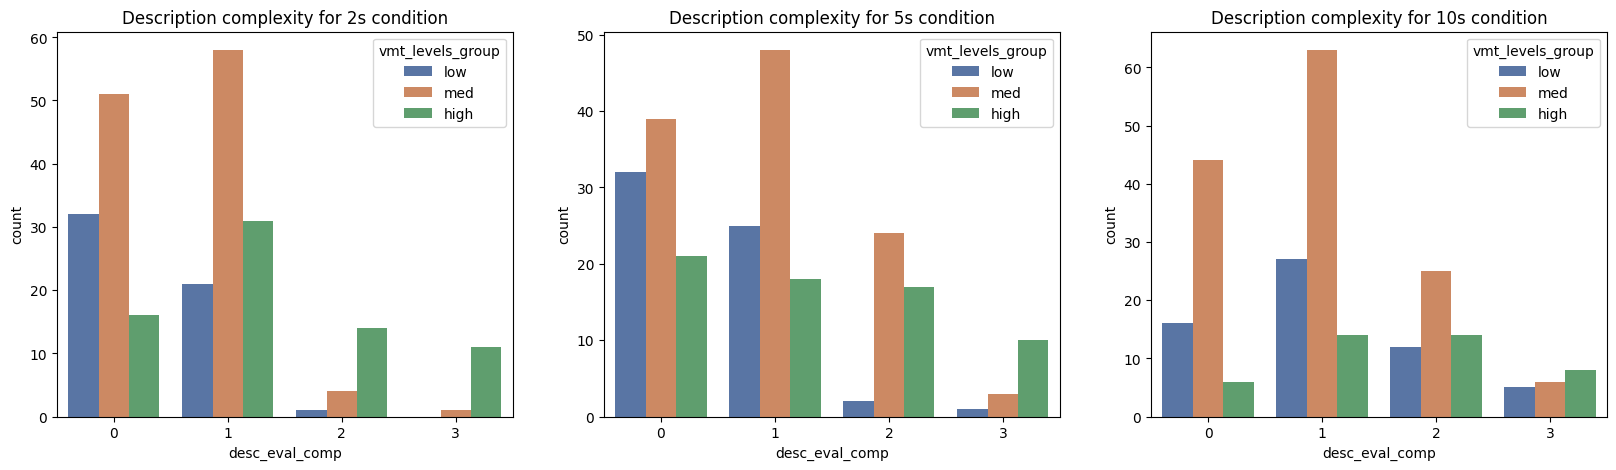

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

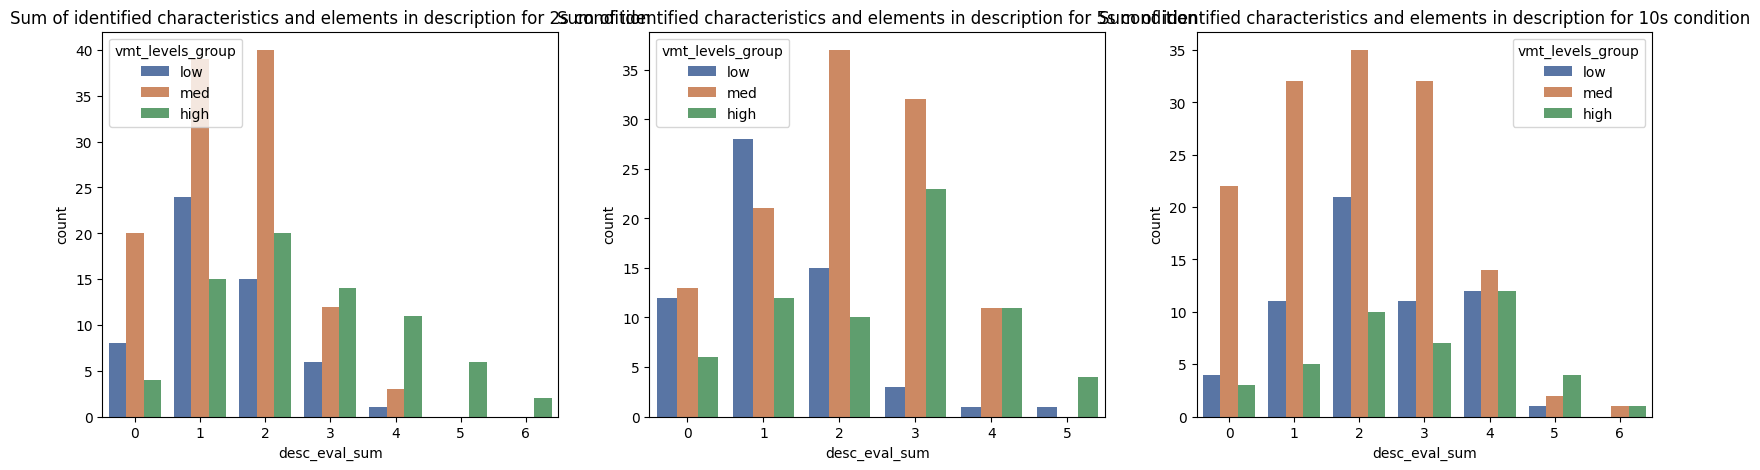

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
for col in ['company', 'purpose', 'detail', 'desc_eval_comp', 'desc_eval_sum']:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
    my_bar_grouped(data[data.interval == '2s'], col, 'vmt_levels_group', open_text[col] + ' for 2s condition', ax=ax1, hue_order=['low', 'med', 'high'])
    my_bar_grouped(data[data.interval == '5s'], col, 'vmt_levels_group', open_text[col] + ' for 5s condition', ax=ax2, hue_order=['low', 'med', 'high'])
    my_bar_grouped(data[data.interval == '10s'], col, 'vmt_levels_group', open_text[col] + ' for 10s condition', ax=ax3, hue_order=['low', 'med', 'high'])

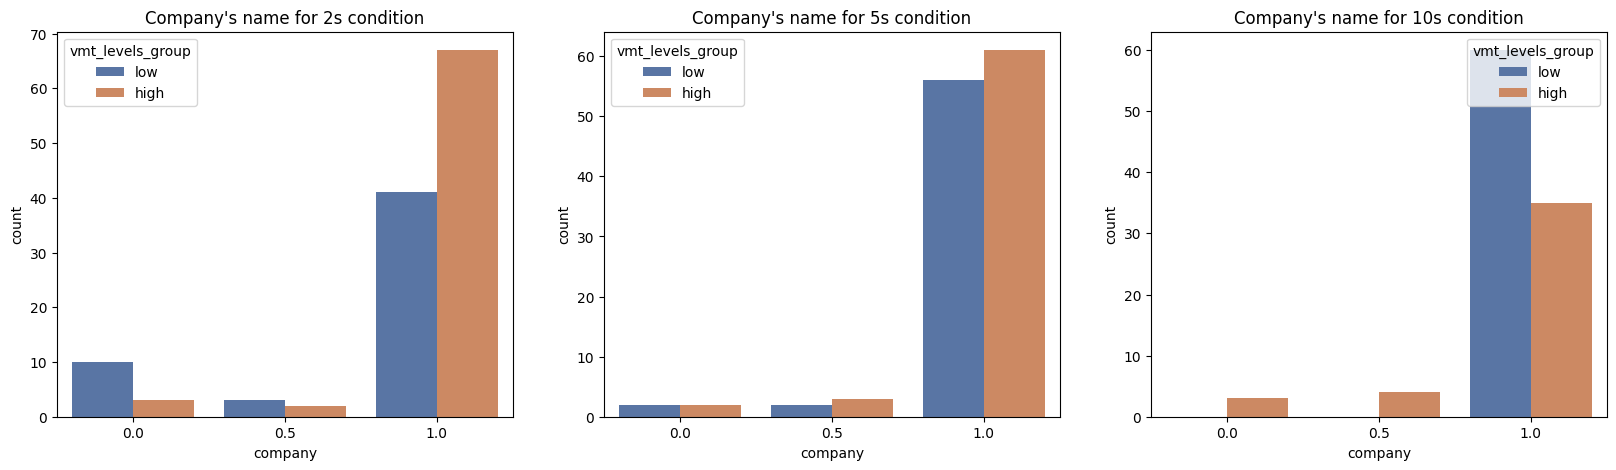

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

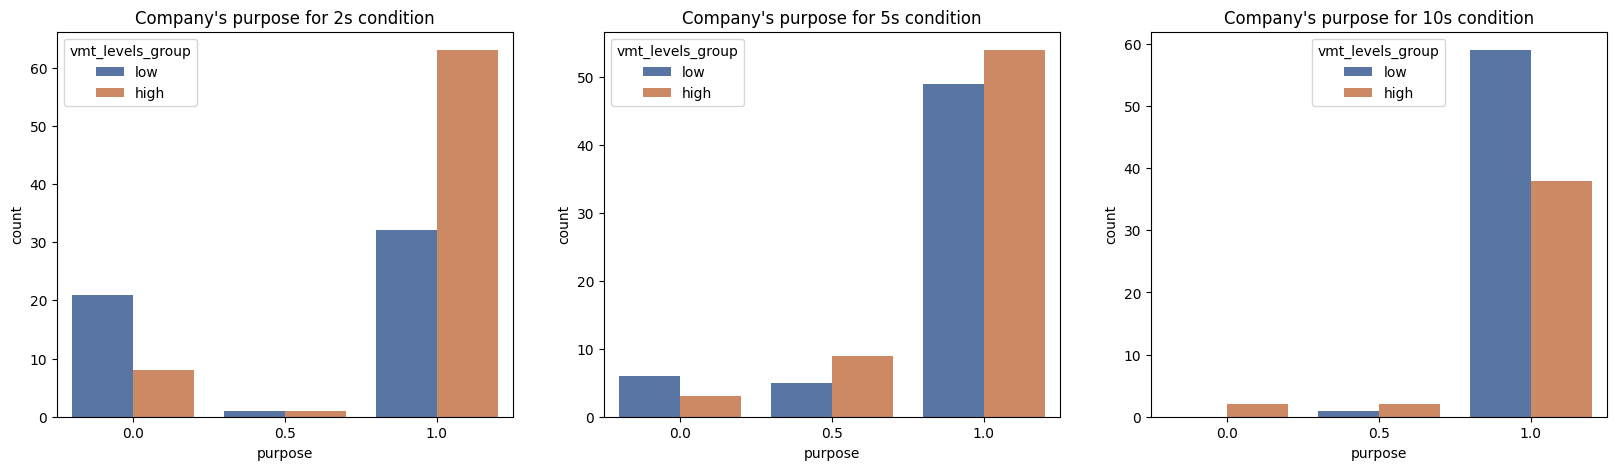

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

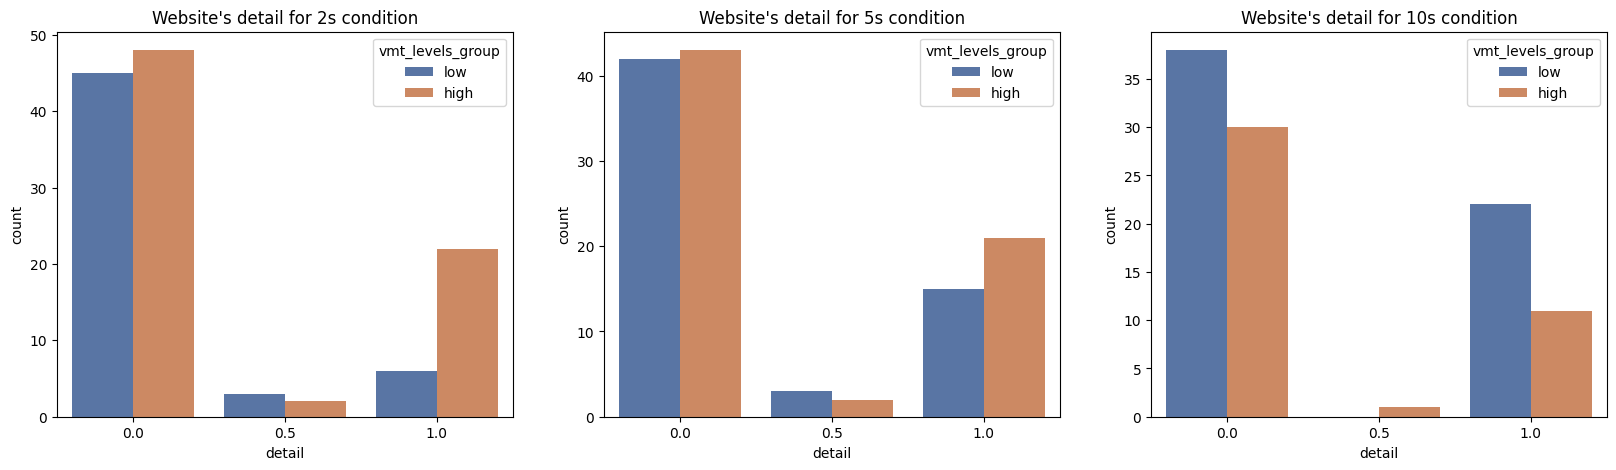

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

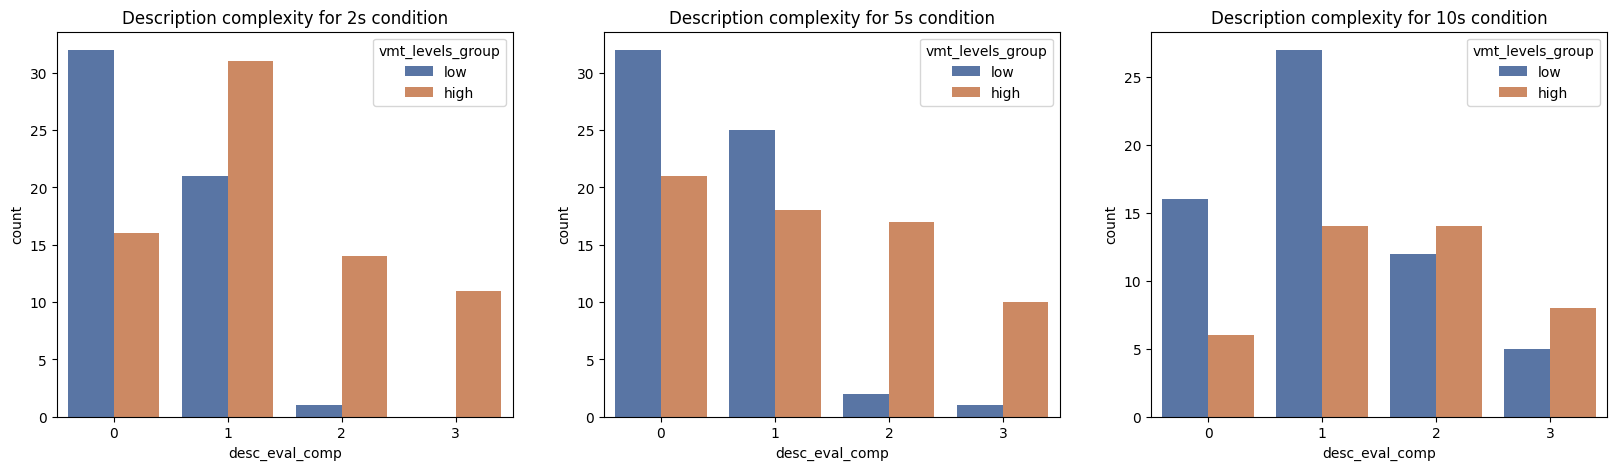

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

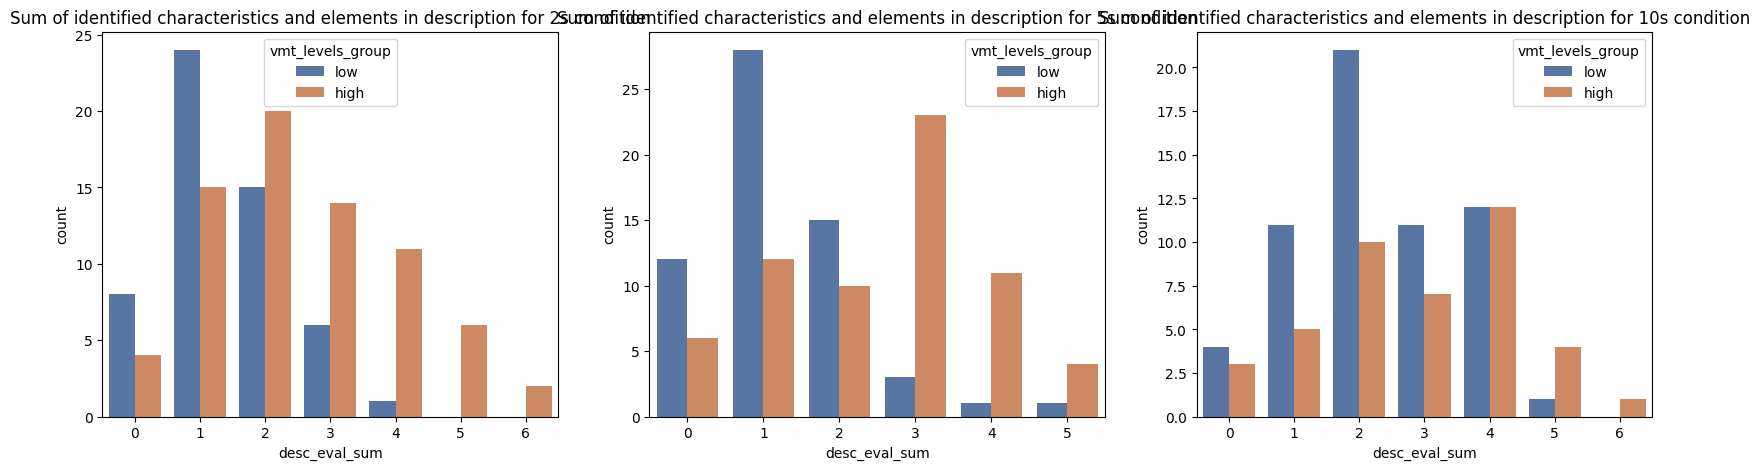

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
for col in ['company', 'purpose', 'detail', 'desc_eval_comp', 'desc_eval_sum']:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
    my_bar_grouped(data[(data.interval == '2s') & (data.vmt_levels_group != 'med')], col, 'vmt_levels_group', open_text[col] + ' for 2s condition', ax=ax1, hue_order=['low', 'high'])
    my_bar_grouped(data[(data.interval == '5s') & (data.vmt_levels_group != 'med')], col, 'vmt_levels_group', open_text[col] + ' for 5s condition', ax=ax2, hue_order=['low', 'high'])
    my_bar_grouped(data[(data.interval == '10s') & (data.vmt_levels_group != 'med')], col, 'vmt_levels_group', open_text[col] + ' for 10s condition', ax=ax3, hue_order=['low', 'high'])

**Complexity and time interval - 2 sec vs. 5 sec.**

In [19]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'vmt_interval', column)

PQ
 pvalue: 0.30517505326169203

HQ
 pvalue: 0.24323673606613985

ATT
 pvalue: 0.29288981213405196



In [20]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '10s'], column, 'vmt_interval', column)

desc_token_count
----> pvalue: 3.010486692646751e-10

Post-hoc testing:
('high_2s', 'med_2s')9.109882159221878e-07                   1
('high_2s', 'low_2s')3.31366539522363e-06                   1
('high_2s', 'med_5s')0.027764772437330183                   1
('high_2s', 'high_5s')  0.7407693077417128                   0
('high_2s', 'low_5s')9.109882159221878e-07                   1
('med_2s', 'low_2s')  0.7407693077417128                   0
('med_2s', 'med_5s')0.0026738188037188286                   1
('med_2s', 'high_5s')0.00026684394398901543                   1
('med_2s', 'low_5s')  0.6926944373184477                   0
('low_2s', 'med_5s')0.0048702881993347175                   1
('low_2s', 'high_5s')0.00038959673499160987                   1
('low_2s', 'low_5s')  0.7407693077417128                   0
('med_5s', 'high_5s') 0.18597811193757444                   0
('med_5s', 'low_5s')0.002548922498473847                   1
('high_5s', 'low_5s')0.0007327267568903867               

**Complexity and time interval - 2 sec vs. 10 sec.**

In [21]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'vmt_interval', column)

PQ
 pvalue: 0.11305935589064556

HQ
 pvalue: 0.23971340710903394

ATT
 pvalue: 0.21497836872421852



In [22]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'vmt_interval', column)

desc_token_count
----> pvalue: 4.02756616419794e-12

Post-hoc testing:
('high_2s', 'med_2s')1.4132653255016358e-06                   1
('high_2s', 'low_2s')3.31366539522363e-06                   1
('high_2s', 'med_10s') 0.02236115999852708                   1
('high_2s', 'high_10s') 0.32485860122179205                   0
('high_2s', 'low_10s') 0.32485860122179205                   0
('med_2s', 'low_2s')  0.7407693077417128                   0
('med_2s', 'med_10s')0.00045032321796888603                   1
('med_2s', 'high_10s')2.195960996494161e-06                   1
('med_2s', 'low_10s')5.145126550109638e-05                   1
('low_2s', 'med_10s')0.000697016812809319                   1
('low_2s', 'high_10s')4.769795816391122e-06                   1
('low_2s', 'low_10s')7.032316364859305e-05                   1
('med_10s', 'high_10s')0.002405492834618754                   1
('med_10s', 'low_10s') 0.32485860122179205                   0
('high_10s', 'low_10s') 0.06893295616552672  

**Complexity and time interval - 5 sec vs. 10 sec.**

In [23]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'vmt_interval', column)

PQ
 pvalue: 0.7537606790236467

HQ
 pvalue: 0.2536113326470352

ATT
 pvalue: 0.5012570885946175



In [24]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'vmt_interval', column)

desc_token_count
----> pvalue: 2.1427810612001355e-06

Post-hoc testing:
('med_5s', 'high_5s') 0.20227682943617947                   0
('med_5s', 'low_5s')0.0035684914978633864                   1
('med_5s', 'med_10s')  0.8564464449920333                   0
('med_5s', 'high_10s')0.012043978145572763                   1
('med_5s', 'low_10s')  0.2912225658575124                   0
('high_5s', 'low_5s') 0.00109909013533558                   1
('high_5s', 'med_10s') 0.11282758411216641                   0
('high_5s', 'high_10s') 0.20227682943617947                   0
('high_5s', 'low_10s')  0.5673015596652864                   0
('low_5s', 'med_10s')0.0007244747059142226                   1
('low_5s', 'high_10s')8.015482637486241e-06                   1
('low_5s', 'low_10s')7.064137729811668e-05                   1
('med_10s', 'high_10s')0.0036082392519281303                   1
('med_10s', 'low_10s')  0.3002080123635785                   0
('high_10s', 'low_10s') 0.09478281472759925   

**Complexity and time - all groups**

In [25]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'vmt_interval', column)

PQ
 pvalue: 0.30517505326169203

HQ
 pvalue: 0.24323673606613985

ATT
 pvalue: 0.29288981213405196



In [26]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data, column, 'vmt_interval', column)

desc_token_count
----> pvalue: 6.731343782414587e-14

Post-hoc testing:
('high_2s', 'med_2s')2.1863717182132508e-06                   1
('high_2s', 'low_2s')4.771678169122027e-06                   1
('high_2s', 'med_5s') 0.03028884265890565                   1
('high_2s', 'high_5s')  0.7619341451057617                   0
('high_2s', 'low_5s')2.1863717182132508e-06                   1
('high_2s', 'med_10s')0.025555611426888086                   1
('high_2s', 'high_10s')  0.3638416333684071                   0
('high_2s', 'low_10s')  0.3638416333684071                   0
('med_2s', 'low_2s')  0.7619341451057617                   0
('med_2s', 'med_5s')0.0028865914015425045                   1
('med_2s', 'high_5s')0.00025617018622945477                   1
('med_2s', 'low_5s')  0.6234249935866031                   0
('med_2s', 'med_10s')0.0005819561586059451                   1
('med_2s', 'high_10s')3.5135375943906572e-06                   1
('med_2s', 'low_10s')7.717689825164458e-05    

**Complexity and time interval - categorical variables.**

In [27]:
my_chi(fixed_data, 'company', 'vmt_interval', {0: [0.5]})

vmt_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
company                                                                      
0.0                7.0      5.0      5.0      0.0    13.0     4.0     12.0   
1.0               35.0     61.0     61.0     60.0    41.0    56.0    126.0   

vmt_interval  med_2s  med_5s  
company                       
0.0             10.0     7.0  
1.0            104.0   107.0  

----> pvalue: 0.0009497841830935551

expected frequencies:
[[  3.70588235   5.82352941   5.82352941   5.29411765   4.76470588
    5.29411765  12.17647059  10.05882353  10.05882353]
 [ 38.29411765  60.17647059  60.17647059  54.70588235  49.23529412
   54.70588235 125.82352941 103.94117647 103.94117647]]

Post-hoc testing:
('high_10s', 'high_2s') 0.36321510337720603                   0
('high_10s', 'high_5s') 0.36321510337720603                   0
('high_10s', 'low_10s') 0.04541931269767559                   1
('high_10s', 'low_2s')  0.8474312322116998     

In [28]:
my_chi(fixed_data, 'purpose', 'vmt_interval', {0: [0.5]})

vmt_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
purpose                                                                      
0.0                4.0      9.0     12.0      1.0    22.0    11.0     20.0   
1.0               38.0     57.0     54.0     59.0    32.0    49.0    118.0   

vmt_interval  med_2s  med_5s  
purpose                       
0.0             32.0    26.0  
1.0             82.0    88.0  

----> pvalue: 2.3777018048287933e-06

expected frequencies:
[[  8.05882353  12.66386555  12.66386555  11.51260504  10.36134454
   11.51260504  26.4789916   21.87394958  21.87394958]
 [ 33.94117647  53.33613445  53.33613445  48.48739496  43.63865546
   48.48739496 111.5210084   92.12605042  92.12605042]]

Post-hoc testing:
('high_10s', 'high_2s')  0.4879709413559685                   0
('high_10s', 'high_5s')  0.2773144784389677                   0
('high_10s', 'low_10s') 0.18570343374157158                   0
('high_10s', 'low_2s')0.009345492488539173    

In [29]:
my_chi(fixed_data, 'detail', 'vmt_interval', {0: [0.5]})

vmt_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
detail                                                                       
0.0               31.0     45.0     45.0     38.0    48.0    45.0     93.0   
1.0               11.0     21.0     21.0     22.0     6.0    15.0     45.0   

vmt_interval  med_2s  med_5s  
detail                        
0.0             94.0    85.0  
1.0             20.0    29.0  

----> pvalue: 0.014401148943138646

expected frequencies:
[[ 30.82352941  48.43697479  48.43697479  44.03361345  39.6302521
   44.03361345 101.27731092  83.66386555  83.66386555]
 [ 11.17647059  17.56302521  17.56302521  15.96638655  14.3697479
   15.96638655  36.72268908  30.33613445  30.33613445]]

Post-hoc testing:
('high_10s', 'high_2s')  0.9119085429939888                   0
('high_10s', 'high_5s')  0.9119085429939888                   0
('high_10s', 'low_10s')   0.646198298036273                   0
('high_10s', 'low_2s') 0.28440296641225377        

In [30]:
my_chi(fixed_data, 'desc_eval_comp', 'vmt_interval', {0: [1], 2: [3]})

vmt_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_comp                                                                 
0                   20.0     45.0     39.0     43.0    53.0    57.0    107.0   
2                   22.0     21.0     27.0     17.0     1.0     3.0     31.0   

vmt_interval    med_2s  med_5s  
desc_eval_comp                  
0                109.0    87.0  
2                  5.0    27.0  

----> pvalue: 2.619684696415257e-15

expected frequencies:
[[ 32.94117647  51.76470588  51.76470588  47.05882353  42.35294118
   47.05882353 108.23529412  89.41176471  89.41176471]
 [  9.05882353  14.23529412  14.23529412  12.94117647  11.64705882
   12.94117647  29.76470588  24.58823529  24.58823529]]

Post-hoc testing:
('high_10s', 'high_2s') 0.03094337671362771                   1
('high_10s', 'high_5s') 0.16673324724701022                   0
('high_10s', 'low_10s')0.016576122770275443                   1
('high_10s', 'low_2s')3.9971485

In [31]:
my_chi(fixed_data, 'desc_eval_elem', 'vmt_interval', {1: [2], 3: [4, 5]})

vmt_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_elem                                                                 
0                    4.0     13.0      9.0     14.0    12.0    18.0     25.0   
1                   14.0     32.0     36.0     29.0    38.0    38.0     77.0   
3                   24.0     21.0     21.0     17.0     4.0     4.0     36.0   

vmt_interval    med_2s  med_5s  
desc_eval_elem                  
0                 28.0    27.0  
1                 81.0    70.0  
3                  5.0    17.0  

----> pvalue: 1.912560122071458e-11

expected frequencies:
[[ 8.82352941 13.86554622 13.86554622 12.60504202 11.34453782 12.60504202
  28.99159664 23.94957983 23.94957983]
 [24.41176471 38.36134454 38.36134454 34.87394958 31.38655462 34.87394958
  80.21008403 66.2605042  66.2605042 ]
 [ 8.76470588 13.77310924 13.77310924 12.5210084  11.26890756 12.5210084
  28.79831933 23.78991597 23.78991597]]

Post-hoc testing:
('high_10s', 'hi

In [32]:
my_chi(fixed_data, 'desc_eval_char', 'vmt_interval', {1: [2, 3]})

vmt_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_char                                                                 
0                   31.0     32.0     35.0     31.0    40.0    47.0    110.0   
1                   11.0     34.0     31.0     29.0    14.0    13.0     28.0   

vmt_interval    med_2s  med_5s  
desc_eval_char                  
0                 84.0    47.0  
1                 30.0    67.0  

----> pvalue: 8.236832309204711e-12

expected frequencies:
[[26.88235294 42.24369748 42.24369748 38.40336134 34.56302521 38.40336134
  88.32773109 72.96638655 72.96638655]
 [15.11764706 23.75630252 23.75630252 21.59663866 19.43697479 21.59663866
  49.67226891 41.03361345 41.03361345]]

Post-hoc testing:
('high_10s', 'high_2s') 0.02174237059092297                   1
('high_10s', 'high_5s') 0.04506505168584112                   1
('high_10s', 'low_10s')0.040024963233286234                   1
('high_10s', 'low_2s')                 1.0       

In [33]:
my_chi(fixed_data, 'desc_eval_sum', 'vmt_interval', {1: [2, 3], 4: [5, 6]})

vmt_interval   high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_sum                                                                 
0                   3.0      4.0      6.0      4.0     8.0    12.0     22.0   
1                  22.0     44.0     45.0     43.0    45.0    46.0     99.0   
4                  17.0     18.0     15.0     13.0     1.0     2.0     17.0   

vmt_interval   med_2s  med_5s  
desc_eval_sum                  
0                20.0    13.0  
1                91.0    90.0  
4                 3.0    11.0  

----> pvalue: 6.11146777522363e-10

expected frequencies:
[[  5.41176471   8.50420168   8.50420168   7.73109244   6.95798319
    7.73109244  17.78151261  14.68907563  14.68907563]
 [ 30.88235294  48.52941176  48.52941176  44.11764706  39.70588235
   44.11764706 101.47058824  83.82352941  83.82352941]
 [  5.70588235   8.96638655   8.96638655   8.1512605    7.33613445
    8.1512605   18.74789916  15.48739496  15.48739496]]

Post-hoc testing:

In [34]:
my_chi(fixed_data, 'desc_word_count_group', 'vmt_interval')

vmt_interval           high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  \
desc_word_count_group                                                        
high                         24       28       36       25       9       8   
low                           5       14       20       13      25      28   
med                          13       24       10       22      20      24   

vmt_interval           med_10s  med_2s  med_5s  
desc_word_count_group                           
high                        46      18      40  
low                         37      53      43  
med                         55      43      31  

----> pvalue: 2.55550677557754e-10

expected frequencies:
[[13.76470588 21.6302521  21.6302521  19.66386555 17.69747899 19.66386555
  45.22689076 37.36134454 37.36134454]
 [14.         22.         22.         20.         18.         20.
  46.         38.         38.        ]
 [14.23529412 22.3697479  22.3697479  20.33613445 18.30252101 20.33613445
  46.77310924

In [35]:
my_chi(fixed_data, 'desc_token_count_group', 'vmt_interval')

vmt_interval            high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  \
desc_token_count_group                                                        
high                          23       23       34       22       4       4   
low                            6       11       20        9      20      29   
med                           13       32       12       29      30      27   

vmt_interval            med_10s  med_2s  med_5s  
desc_token_count_group                           
high                         43      15      34  
low                          37      43      35  
med                          58      56      45  

----> pvalue: 1.4256397269927215e-12

expected frequencies:
[[11.88235294 18.67226891 18.67226891 16.97478992 15.27731092 16.97478992
  39.04201681 32.25210084 32.25210084]
 [12.35294118 19.41176471 19.41176471 17.64705882 15.88235294 17.64705882
  40.58823529 33.52941176 33.52941176]
 [17.76470588 27.91596639 27.91596639 25.37815126 22.84033613 25.37

## PST levels

**Mean.**

In [36]:
data[['task', 'pst_levels_correct_group'] + list(attrak.keys())].groupby(['task', 'pst_levels_correct_group']).mean()

PQ1       PQ2       PQ3       PQ4  \
task pst_levels_correct_group                                           
1    high                      6.057143  5.628571  5.400000  5.914286   
     low                       5.361111  5.305556  5.000000  5.305556   
     med                       5.959184  5.816327  5.265306  5.938776   
2    high                      5.142857  5.114286  4.942857  5.085714   
     low                       5.277778  5.416667  4.805556  5.138889   
     med                       5.163265  5.265306  4.938776  5.000000   
3    high                      4.800000  5.285714  4.714286  5.085714   
     low                       4.833333  5.333333  4.944444  5.388889   
     med                       4.897959  4.959184  4.734694  4.897959   
4    high                      4.914286  5.514286  5.257143  4.971429   
     low                       4.555556  5.472222  5.138889  5.027778   
     med                       4.755102  5.551020  5.571429  5.346939   
5    high                      3.885714  4.028571  4.314286  3.942857   
     low                       3.972222  4.583333  4.250000  4.194444   
     med                       4.244898  4.510204  4.306122  3.938776   
6    high                      3.200000  3.828571  4.171429  3.657143   
     low                       2.611111  3.638889  3.944444  3.083333   
     med                       3.183673  4.244898  4.469388  3.938776   

                                    HQ1       HQ2       HQ3       HQ4  \
task pst_levels_correct_group                                           
1    high                      5.285714  4.771429  4.285714  4.485714   
     low                       4.583333  4.361111  3.972222  3.861111   
     med                       5.306122  4.836735  4.306122  4.530612   
2    high                      4.257143  4.285714  3.800000  3.971429   
     low                       4.777778  4.583333  4.361111  4.416667   
     med                       4.755102  4.469388  4.265306  4.387755   
3    high                      4.971429  4.828571  4.457143  4.628571   
     low                       5.055556  4.916667  4.805556  4.833333   
     med                       4.632653  4.714286  4.448980  4.693878   
4    high                      4.057143  3.628571  3.457143  3.885714   
     low                       4.444444  4.027778  4.027778  4.333333   
     med                       4.244898  3.816327  3.877551  4.000000   
5    high                      3.142857  3.000000  3.285714  3.628571   
     low                       3.694444  3.305556  3.916667  4.083333   
     med                       3.306122  3.122449  3.469388  3.816327   
6    high                      3.628571  3.571429  2.685714  2.885714   
     low                       3.555556  3.527778  3.138889  3.055556   
     med                       3.877551  3.775510  3.122449  3.183673   

                                   ATT1      ATT2        PQ        HQ  \
task pst_levels_correct_group                                           
1    high                      5.342857  5.457143  5.750000  4.707143   
     low                       4.777778  4.888889  5.243056  4.194444   
     med                       5.469388  5.428571  5.744898  4.744898   
2    high                      4.828571  4.657143  5.071429  4.078571   
     low                       4.944444  4.777778  5.159722  4.534722   
     med                       4.959184  4.836735  5.091837  4.469388   
3    high                      4.971429  5.085714  4.971429  4.721429   
     low                       5.388889  5.305556  5.125000  4.902778   
     med                       5.061224  4.897959  4.872449  4.622449   
4    high                      4.114286  4.657143  5.164286  3.757143   
     low                       4.583333  5.083333  5.048611  4.208333   
     med                       4.306122  4.897959  5.306122  3.984694   
5    high                      3.200000  3.657143  4.042857  3.264286   
     low           

In [37]:
data[['task', 'pst_levels_correct_group'] + list(open_text.keys())].groupby(['task', 'pst_levels_correct_group']).mean()

company   purpose  purpose_token_count  \
task pst_levels_correct_group                                            
1    high                      1.000000  0.971429             2.114286   
     low                       0.888889  0.972222             2.722222   
     med                       0.979592  0.959184             2.265306   
2    high                      0.914286  0.885714             3.085714   
     low                       0.833333  0.694444             2.638889   
     med                       0.928571  0.877551             2.836735   
3    high                      0.914286  0.985714             3.228571   
     low                       0.805556  0.791667             3.083333   
     med                       0.908163  0.887755             2.734694   
4    high                      0.971429  1.000000             2.571429   
     low                       0.958333  1.000000             2.750000   
     med                       1.000000  0.979592             2.571429   
5    high                      0.914286  0.785714             2.342857   
     low                       0.916667  0.652778             2.888889   
     med                       0.959184  0.775510             1.857143   
6    high                      0.928571  0.700000             2.800000   
     low                       0.833333  0.555556             2.305556   
     med                       0.989796  0.704082             2.918367   

                               purpose_word_count    detail  desc_eval_comp  \
task pst_levels_correct_group                                                 
1    high                                2.771429  0.200000        1.285714   
     low                                 4.305556  0.111111        0.833333   
     med                                 3.326531  0.265306        1.102041   
2    high                                4.085714  0.671429        1.000000   
     low                                 3.944444  0.638889        0.805556   
     med                                 3.959184  0.479592        0.897959   
3    high                                3.942857  0.257143        1.114286   
     low                                 4.833333  0.208333        0.750000   
     med                                 4.061224  0.102041        1.061224   
4    high                                4.428571  0.457143        1.114286   
     low                                 3.972222  0.180556        0.833333   
     med                                 3.755102  0.244898        1.020408   
5    high                                4.085714  0.214286        0.914286   
     low                                 6.305556  0.347222        0.694444   
     med                                 3.551020  0.346939        0.653061   
6    high                                4.914286  0.085714        1.028571   
     low                                 4.555556  0.111111        0.666667   
     med                                 5.122449  0.112245        0.877551   

                               desc_eval_elem  desc_eval_char  desc_eval_sum  \
task pst_levels_correct_group                                                  
1    high                            1.714286        0.800000       2.514286   
     low                             1.166667        0.388889       1.555556   
     med                             1.591837        0.571429       2.163265   
2    high                            1.714286        0.428571       2.142857   
     low                             1.472222        0.250000       1.722222   
     med                             1.551020        0.571429       2.122449   
3    high                            2.257143        0.200000       2.457143   
     low                             1.638889        0.111111       1.750000   
     med                             2.061224        0.306122       2.367347   
4    high                            1.742857        0.371429       2.114286   
     low  

**Median.**

In [38]:
data[['task', 'pst_levels_correct_group'] + list(attrak.keys())].groupby(['task', 'pst_levels_correct_group']).median()

PQ1  PQ2  PQ3  PQ4  HQ1  HQ2  HQ3  HQ4  ATT1  \
task pst_levels_correct_group                                                 
1    high                      6.0  6.0  5.0  6.0  5.0  5.0  4.0  5.0   5.0   
     low                       6.0  5.5  5.0  5.0  5.0  4.5  4.0  4.0   5.0   
     med                       6.0  6.0  5.0  6.0  5.0  5.0  4.0  5.0   6.0   
2    high                      5.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   5.0   
     low                       5.0  6.0  5.0  5.0  5.0  4.0  4.0  4.0   5.0   
     med                       5.0  5.0  5.0  5.0  5.0  4.0  4.0  4.0   5.0   
3    high                      5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   5.0   
     low                       5.0  5.0  5.0  5.5  5.0  5.0  5.0  5.0   5.0   
     med                       5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0   5.0   
4    high                      5.0  6.0  5.0  5.0  4.0  4.0  3.0  4.0   4.0   
     low                       4.0  6.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   
     med                       5.0  6.0  6.0  5.0  4.0  4.0  4.0  4.0   4.0   
5    high                      4.0  4.0  4.0  4.0  3.0  3.0  3.0  4.0   3.0   
     low                       4.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0   4.0   
     med                       5.0  5.0  4.0  4.0  3.0  3.0  3.0  4.0   4.0   
6    high                      3.0  4.0  4.0  3.0  4.0  4.0  3.0  3.0   3.0   
     low                       2.0  4.0  4.0  3.0  4.0  4.0  3.0  3.0   3.0   
     med                       3.0  4.0  5.0  4.0  4.0  4.0  3.0  3.0   3.0   

                               ATT2     PQ     HQ  ATT  
task pst_levels_correct_group                           
1    high                       6.0  5.750  4.750  5.5  
     low                        5.0  5.250  4.250  5.0  
     med                        6.0  5.750  4.750  5.5  
2    high                       5.0  5.000  4.000  5.0  
     low                        5.0  5.375  4.500  5.0  
     med                        5.0  5.250  4.250  5.0  
3    high                       5.0  5.000  4.750  5.0  
     low                        5.0  5.000  5.000  5.5  
     med                        5.0  5.250  4.500  5.0  
4    high                       4.0  5.250  3.750  4.5  
     low                        5.0  5.000  4.125  5.0  
     med                        5.0  5.250  4.000  4.5  
5    high                       4.0  4.250  3.000  3.0  
     low                        4.0  4.125  3.875  4.0  
     med                        4.0  4.250  3.250  4.0  
6    high                       4.0  3.750  3.250  3.0  
     low                        3.5  3.375  3.250  3.0  
     med                        4.0  4.000  3.500  3.5

In [39]:
data[['task', 'pst_levels_correct_group'] + list(open_text.keys())].groupby(['task', 'pst_levels_correct_group']).median()

company  purpose  purpose_token_count  \
task pst_levels_correct_group                                          
1    high                          1.0      1.0                  2.0   
     low                           1.0      1.0                  2.0   
     med                           1.0      1.0                  2.0   
2    high                          1.0      1.0                  3.0   
     low                           1.0      1.0                  2.0   
     med                           1.0      1.0                  3.0   
3    high                          1.0      1.0                  3.0   
     low                           1.0      1.0                  3.0   
     med                           1.0      1.0                  2.0   
4    high                          1.0      1.0                  2.0   
     low                           1.0      1.0                  2.0   
     med                           1.0      1.0                  2.0   
5    high                          1.0      1.0                  2.0   
     low                           1.0      1.0                  2.0   
     med                           1.0      1.0                  2.0   
6    high                          1.0      1.0                  2.0   
     low                           1.0      0.5                  2.0   
     med                           1.0      1.0                  2.0   

                               purpose_word_count  detail  desc_eval_comp  \
task pst_levels_correct_group                                               
1    high                                     2.0     0.0             1.0   
     low                                      3.0     0.0             1.0   
     med                                      2.0     0.0             1.0   
2    high                                     3.0     1.0             1.0   
     low                                      3.0     1.0             1.0   
     med                                      3.0     0.0             1.0   
3    high                                     4.0     0.0             1.0   
     low                                      3.0     0.0             1.0   
     med                                      3.0     0.0             1.0   
4    high                                     3.0     0.0             1.0   
     low                                      3.0     0.0             1.0   
     med                                      3.0     0.0             1.0   
5    high                                     3.0     0.0             1.0   
     low                                      3.0     0.0             1.0   
     med                                      2.0     0.0             1.0   
6    high                                     4.0     0.0             1.0   
     low                                      3.0     0.0             1.0   
     med                                      3.0     0.0             1.0   

                               desc_eval_elem  desc_eval_char  desc_eval_sum  \
task pst_levels_correct_group                                                  
1    high                                 1.0             1.0            2.0   
     low                                  1.0             0.0            1.0   
     med                                  1.0             0.0            2.0   
2    high                                 2.0             0.0            2.0   
     low                                  1.0             0.0            2.0   
     med                                  1.0             0.0            2.0   
3    high                                 2.0             0.0            2.0   
     low                                  2.0             0.0            2.0   
     med                                  2.0             0.0            2.0   
4    high                                 1.0             0.0            2.0   
     low                                  1.0             0.0            2.0   
     med 

**Std.**

In [40]:
data[['task', 'pst_levels_correct_group'] + list(attrak.keys())].groupby(['task', 'pst_levels_correct_group']).std()

PQ1       PQ2       PQ3       PQ4  \
task pst_levels_correct_group                                           
1    high                      0.905631  0.972738  1.034692  1.010865   
     low                       1.245627  1.064208  1.041976  1.166667   
     med                       0.999149  0.858134  1.016028  0.944461   
2    high                      1.309307  1.131668  1.258918  1.314432   
     low                       1.233140  1.227657  1.348426  1.514742   
     med                       0.943110  0.952530  1.214636  1.338532   
3    high                      0.994100  1.016668  1.100038  1.314432   
     low                       1.207122  0.985611  0.954521  0.934353   
     med                       1.294940  1.413612  1.186302  1.530862   
4    high                      1.379928  0.981338  1.421326  1.294461   
     low                       1.229273  1.298045  1.125110  1.081959   
     med                       1.521110  1.191309  1.080123  1.199844   
5    high                      1.586180  1.580873  1.323352  1.661729   
     low                       1.594385  1.360147  1.360147  1.670234   
     med                       1.422009  1.324803  1.278086  1.625425   
6    high                      1.568064  1.424279  1.382362  1.661729   
     low                       1.399546  1.570310  1.529602  1.592393   
     med                       1.666752  1.465302  1.385972  1.599585   

                                    HQ1       HQ2       HQ3       HQ4  \
task pst_levels_correct_group                                           
1    high                      0.925820  1.086974  1.226459  1.245496   
     low                       1.180194  1.245627  1.383290  1.125110   
     med                       1.158377  1.296581  1.261680  1.487476   
2    high                      0.980482  1.045197  0.994100  0.857003   
     low                       1.197882  1.250714  1.312637  1.338976   
     med                       1.109253  1.415716  1.271081  1.288027   
3    high                      1.150082  1.042782  1.171797  1.113704   
     low                       1.119807  1.024695  1.214659  1.028175   
     med                       1.253227  1.241639  1.308008  1.278086   
4    high                      0.725293  0.972738  1.120474  1.278129   
     low                       0.998411  1.182881  1.158475  0.925820   
     med                       1.071032  1.148794  1.129761  1.307032   
5    high                      1.478132  1.414214  1.466718  1.415995   
     low                       1.348426  1.260826  1.480830  1.500000   
     med                       1.278086  1.111168  1.138384  1.219178   
6    high                      1.190297  1.219588  1.254906  1.254906   
     low                       1.026630  0.909823  1.396992  1.240839   
     med                       0.971096  1.229250  1.129761  1.201968   

                                   ATT1      ATT2        PQ        HQ  \
task pst_levels_correct_group                                           
1    high                      1.136115  1.066684  0.797515  0.946133   
     low                       1.072010  0.949520  0.856667  1.021398   
     med                       1.209374  1.154701  0.786424  1.180891   
2    high                      1.070616  1.109925  1.128787  0.768812   
     low                       1.263656  1.375523  1.085872  1.198441   
     med                       1.171879  1.213585  0.896599  1.115274   
3    high                      1.248192  0.950895  0.848380  0.960184   
     low                       1.049565  0.950772  0.752377  0.980666   
     med                       1.197361  1.245741  1.173850  1.105293   
4    high                      1.157366  0.802308  0.952826  0.819087   
     low                       0.937321  1.180194  0.907940  0.926784   
     med                       1.294284  1.103874  1.092428  1.031292   
5    high                      1.491150  1.454058  1.330477  1.320014   
     low           

In [41]:
data[['task', 'pst_levels_correct_group'] + list(open_text.keys())].groupby(['task', 'pst_levels_correct_group']).std()

company   purpose  purpose_token_count  \
task pst_levels_correct_group                                            
1    high                      0.000000  0.169031             1.105373   
     low                       0.318728  0.166667             1.950987   
     med                       0.142857  0.199915             1.319336   
2    high                      0.256839  0.299158             1.704172   
     low                       0.358569  0.467177             1.899666   
     med                       0.250000  0.331201             1.885768   
3    high                      0.256839  0.084515             1.646488   
     low                       0.364060  0.403113             1.962142   
     med                       0.282722  0.310666             1.901485   
4    high                      0.169031  0.000000             1.440705   
     low                       0.184197  0.000000             1.826394   
     med                       0.000000  0.142857             1.399405   
5    high                      0.256839  0.407390             1.454058   
     low                       0.280306  0.460116             3.591878   
     med                       0.138321  0.396091             1.241639   
6    high                      0.214985  0.367823             1.694281   
     low                       0.377964  0.410188             2.108750   
     med                       0.071429  0.366833             2.187433   

                               purpose_word_count    detail  desc_eval_comp  \
task pst_levels_correct_group                                                 
1    high                                2.030441  0.405840        1.072968   
     low                                 4.097522  0.318728        0.878310   
     med                                 2.664487  0.446071        0.918443   
2    high                                2.821883  0.468773        0.907485   
     low                                 3.593203  0.472246        0.920231   
     med                                 3.599532  0.499575        0.770414   
3    high                                2.448804  0.443440        0.758149   
     low                                 4.266146  0.403113        0.691789   
     med                                 4.125167  0.305839        0.944461   
4    high                                4.742088  0.505433        0.900047   
     low                                 3.434997  0.380841        0.736788   
     med                                 2.989779  0.422326        1.030570   
5    high                                3.128347  0.407390        0.886879   
     low                                10.563602  0.460116        0.709907   
     med                                 3.323284  0.469974        0.751416   
6    high                                3.689185  0.284029        1.042782   
     low                                 4.391189  0.318728        0.717137   
     med                                 6.240435  0.293423        0.780829   

                               desc_eval_elem  desc_eval_char  desc_eval_sum  \
task pst_levels_correct_group                                                  
1    high                            1.072968        0.964060       1.462702   
     low                             0.941124        0.598941       1.132493   
     med                             1.171153        0.677003       1.264037   
2    high                            1.202239        0.698137       1.263582   
     low                             1.133543        0.439155       1.161553   
     med                             1.042058        0.677003       1.268737   
3    high                            1.171797        0.472789       1.313792   
     low                             1.099423        0.318728       1.155731   
     med                             1.297564        0.547878       1.364641   
4    high                            1.196634        0.645606       1.300937   
     low  

**Plots**

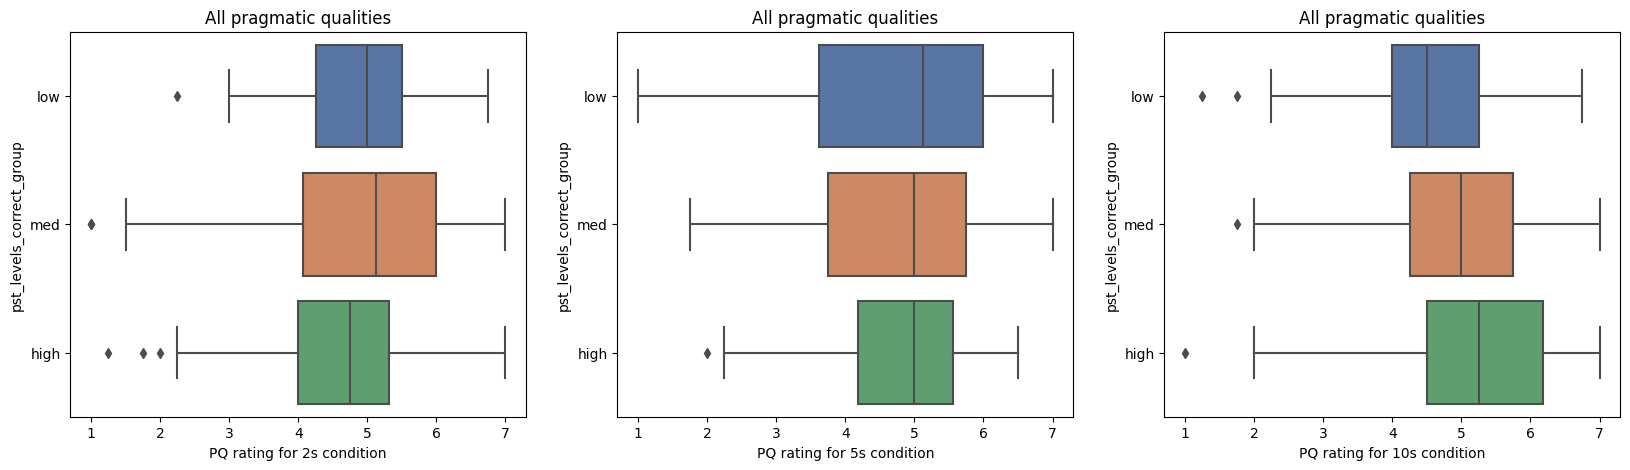

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'PQ', 'pst_levels_correct_group', attrak['PQ'], 'PQ rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'PQ', 'pst_levels_correct_group', attrak['PQ'], 'PQ rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'PQ', 'pst_levels_correct_group', attrak['PQ'], 'PQ rating for 10s condition', ax3, order=['low', 'med', 'high'])

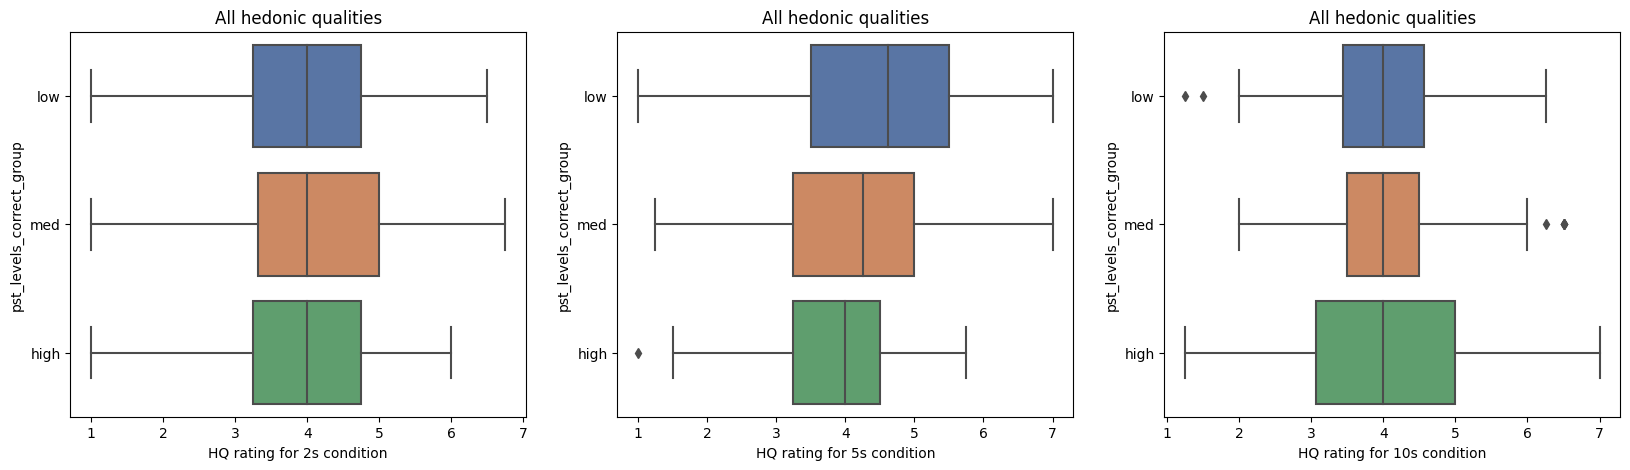

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'HQ', 'pst_levels_correct_group', attrak['HQ'], 'HQ rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'HQ', 'pst_levels_correct_group', attrak['HQ'], 'HQ rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'HQ', 'pst_levels_correct_group', attrak['HQ'], 'HQ rating for 10s condition', ax3, order=['low', 'med', 'high'])

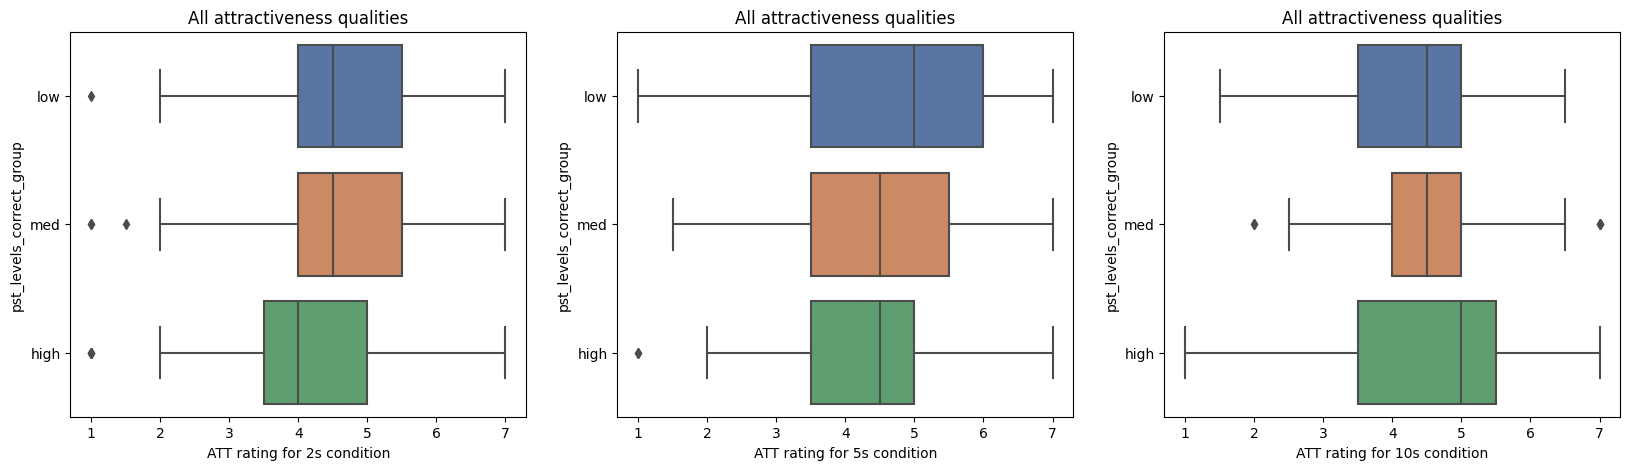

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'ATT', 'pst_levels_correct_group', attrak['ATT'], 'ATT rating for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'ATT', 'pst_levels_correct_group', attrak['ATT'], 'ATT rating for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'ATT', 'pst_levels_correct_group', attrak['ATT'], 'ATT rating for 10s condition', ax3, order=['low', 'med', 'high'])

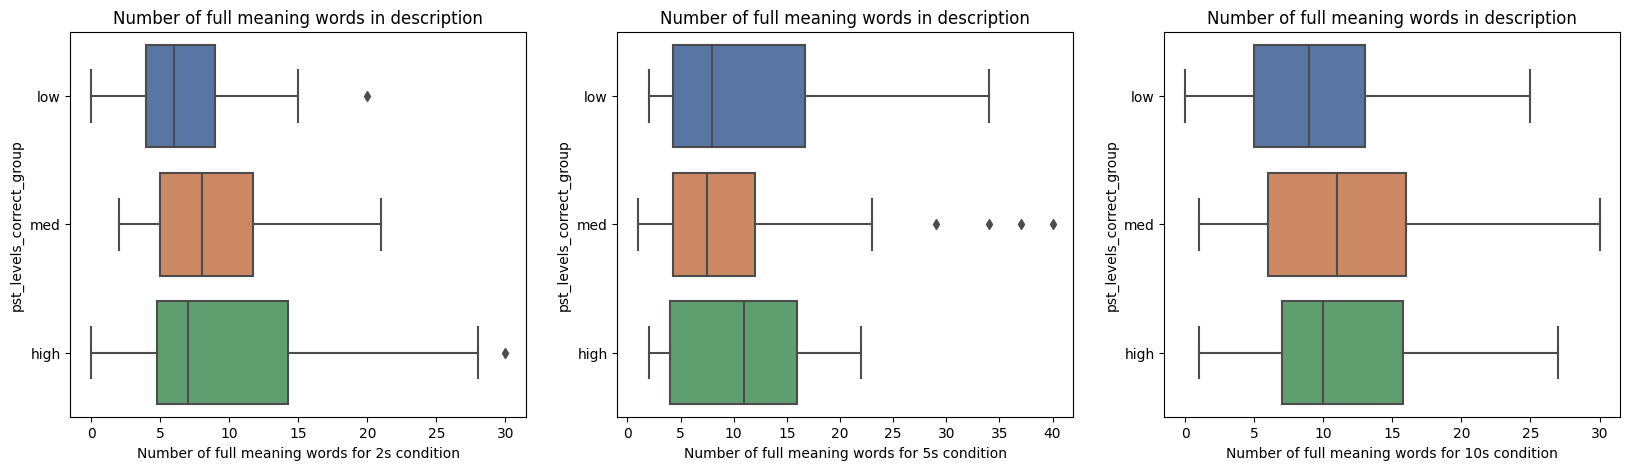

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'desc_token_count', 'pst_levels_correct_group', open_text['desc_token_count'], 'Number of full meaning words for 2s condition', ax1, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '5s'], 'desc_token_count', 'pst_levels_correct_group', open_text['desc_token_count'], 'Number of full meaning words for 5s condition', ax2, order=['low', 'med', 'high'])
my_box_xy(data[data.interval == '10s'], 'desc_token_count', 'pst_levels_correct_group', open_text['desc_token_count'], 'Number of full meaning words for 10s condition', ax3, order=['low', 'med', 'high'])

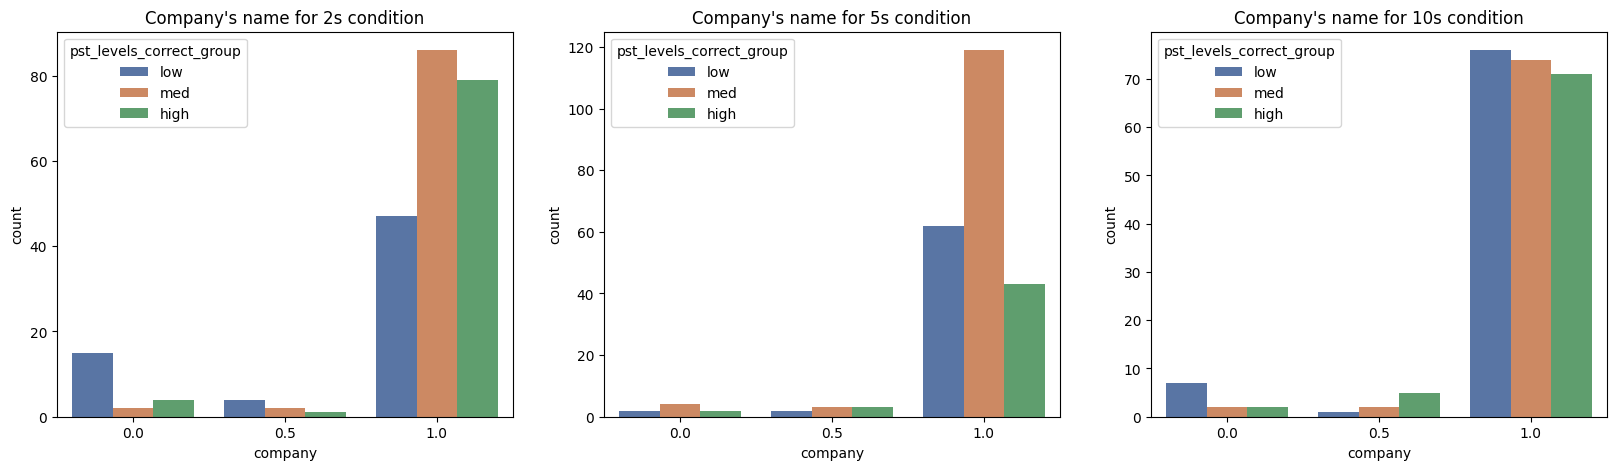

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

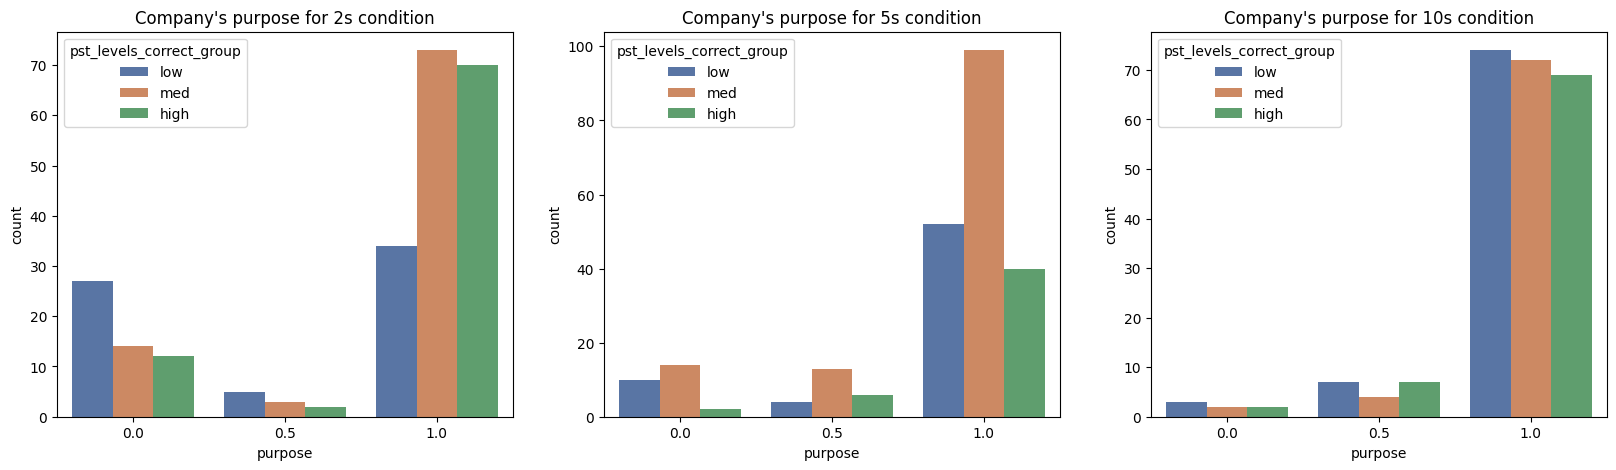

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

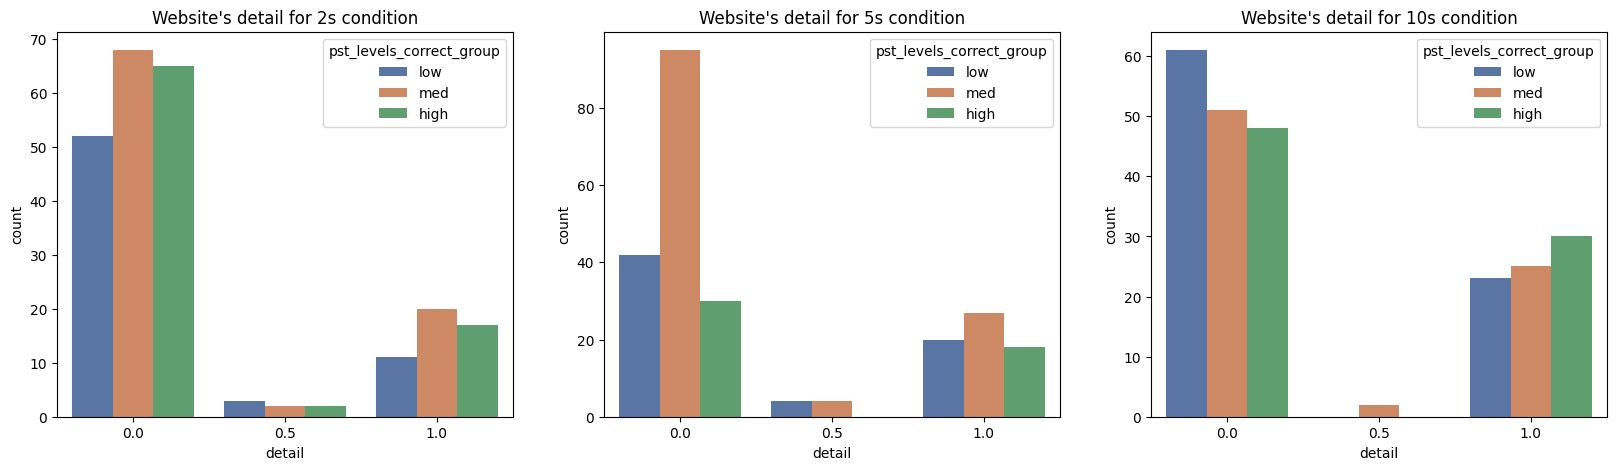

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

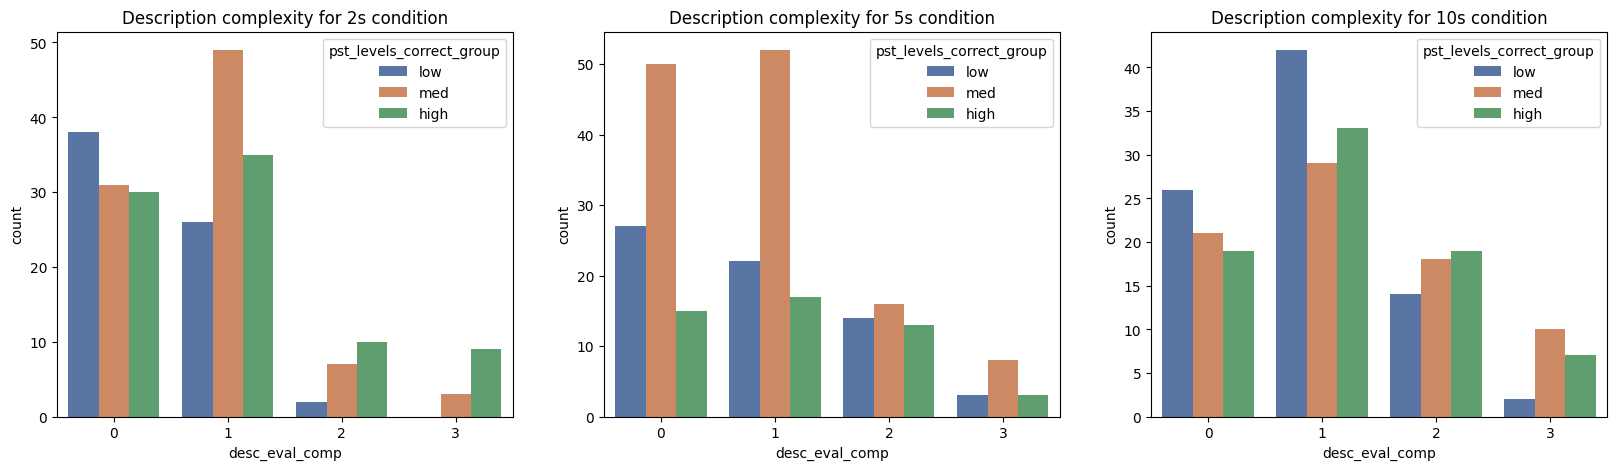

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

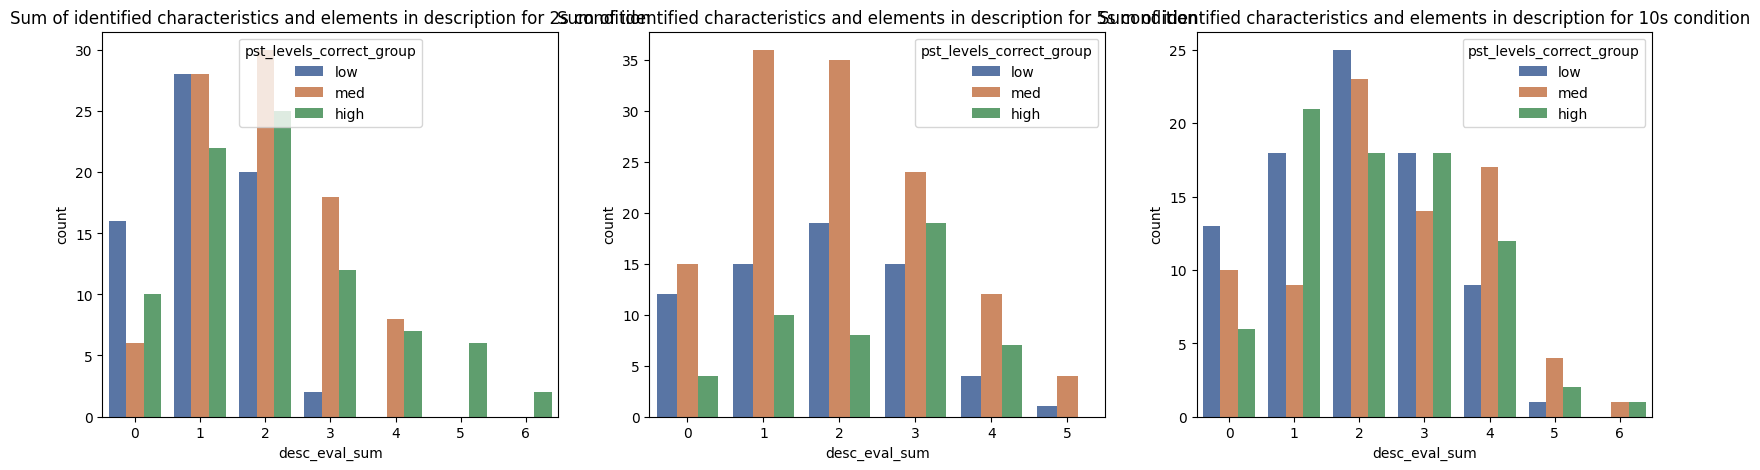

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [46]:
for col in ['company', 'purpose', 'detail', 'desc_eval_comp', 'desc_eval_sum']:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
    my_bar_grouped(data[data.interval == '2s'], col, 'pst_levels_correct_group', open_text[col] + ' for 2s condition', ax=ax1, hue_order=['low', 'med', 'high'])
    my_bar_grouped(data[data.interval == '5s'], col, 'pst_levels_correct_group', open_text[col] + ' for 5s condition', ax=ax2, hue_order=['low', 'med', 'high'])
    my_bar_grouped(data[data.interval == '10s'], col, 'pst_levels_correct_group', open_text[col] + ' for 10s condition', ax=ax3, hue_order=['low', 'med', 'high'])

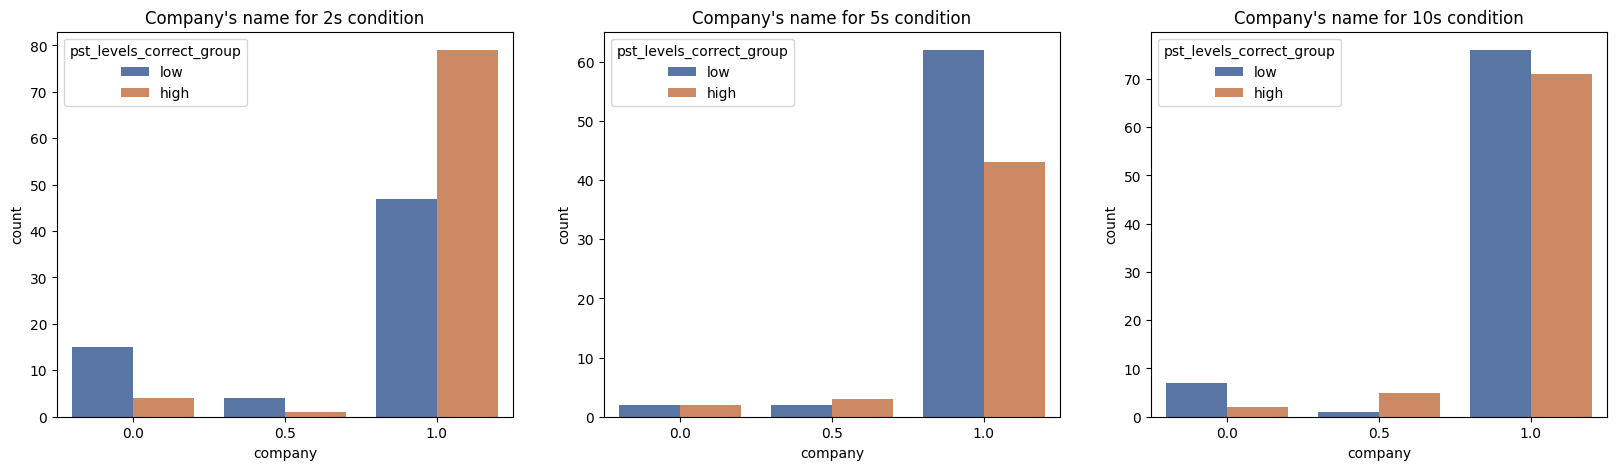

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

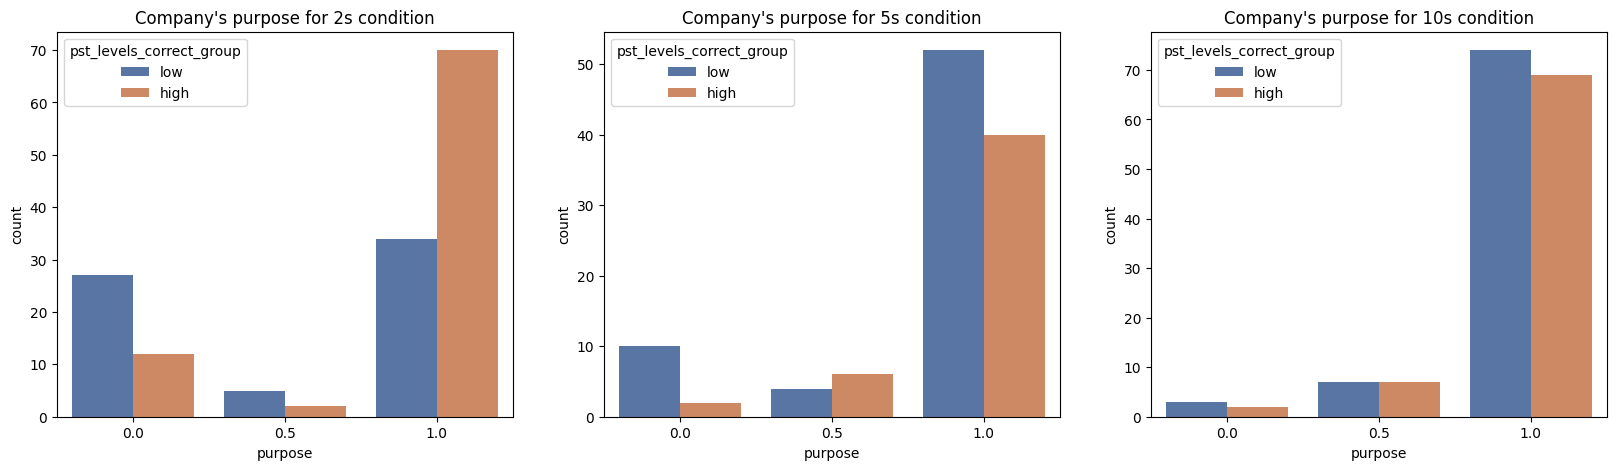

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

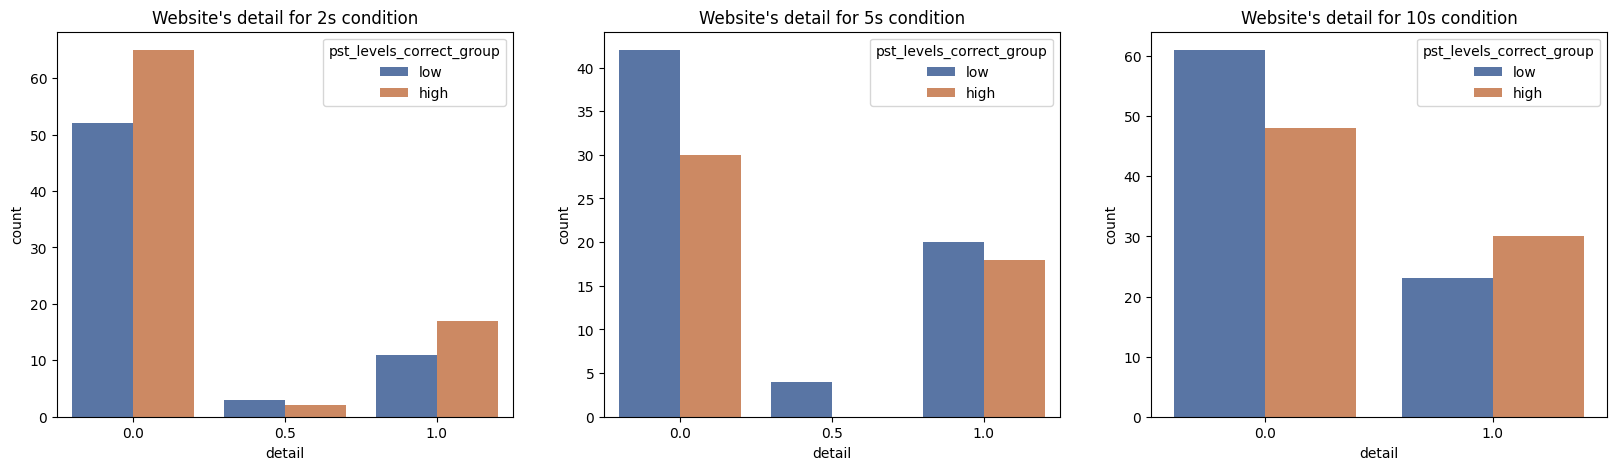

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

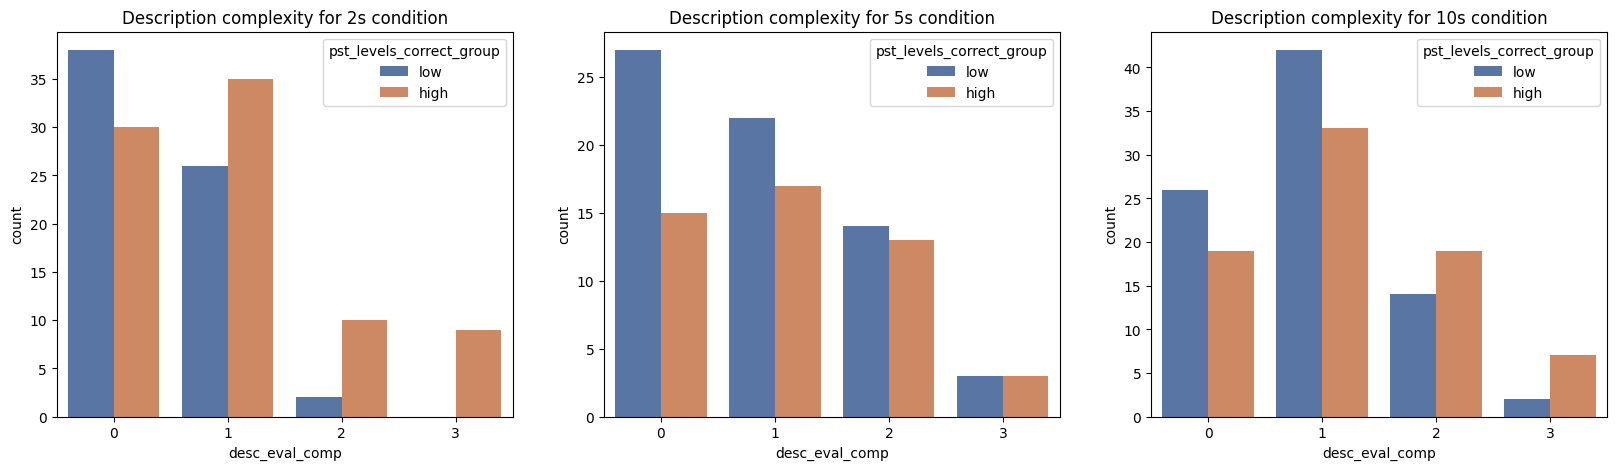

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

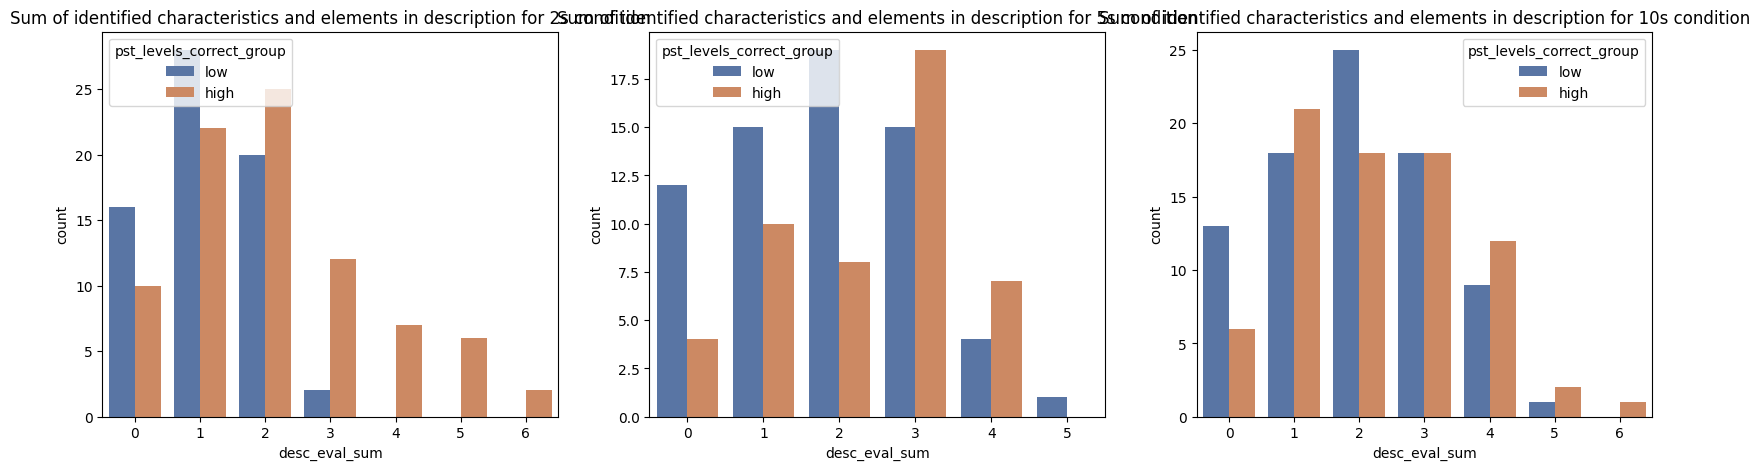

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
for col in ['company', 'purpose', 'detail', 'desc_eval_comp', 'desc_eval_sum']:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
    my_bar_grouped(data[(data.interval == '2s') & (data.pst_levels_correct_group != 'med')], col, 'pst_levels_correct_group', open_text[col] + ' for 2s condition', ax=ax1, hue_order=['low', 'high'])
    my_bar_grouped(data[(data.interval == '5s') & (data.pst_levels_correct_group != 'med')], col, 'pst_levels_correct_group', open_text[col] + ' for 5s condition', ax=ax2, hue_order=['low', 'high'])
    my_bar_grouped(data[(data.interval == '10s') & (data.pst_levels_correct_group != 'med')], col, 'pst_levels_correct_group', open_text[col] + ' for 10s condition', ax=ax3, hue_order=['low', 'high'])

**Complexity and time interval - 2 sec vs. 5 sec.**

In [48]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '10s'], column, 'pst_interval', column)

PQ
 pvalue: 0.19036254410468

HQ
 pvalue: 0.12452702269513381

ATT
 pvalue: 0.09058902328074817



In [49]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '10s'], column, 'pst_interval', column)

desc_token_count
----> pvalue: 0.044200273876753134

Post-hoc testing:
('med_2s', 'low_2s')   0.135846140912771                   0
('med_2s', 'high_2s')  0.9771175083743323                   0
('med_2s', 'low_5s')  0.7122904720689227                   0
('med_2s', 'med_5s')  0.7122904720689227                   0
('med_2s', 'high_5s') 0.18975402581113368                   0
('low_2s', 'high_2s') 0.17264128071709806                   0
('low_2s', 'low_5s')   0.135846140912771                   0
('low_2s', 'med_5s') 0.18975402581113368                   0
('low_2s', 'high_5s')0.014520819083697163                   1
('high_2s', 'low_5s')  0.7122904720689227                   0
('high_2s', 'med_5s')  0.7294949905569946                   0
('high_2s', 'high_5s')  0.4429206875092037                   0
('low_5s', 'med_5s')  0.5001016402568583                   0
('low_5s', 'high_5s')  0.8573821712038849                   0
('med_5s', 'high_5s') 0.17264128071709806                   0





**Complexity and time interval - 5 sec vs. 10 sec.**

In [50]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'pst_interval', column)

PQ
----> pvalue: 0.012784319660761274

Post-hoc testing:
('low_5s', 'med_5s')  0.4472016040809286                   0
('low_5s', 'high_5s') 0.49345180496934143                   0
('low_5s', 'med_10s')  0.7560447860562095                   0
('low_5s', 'high_10s')  0.7560447860562095                   0
('low_5s', 'low_10s') 0.07158308356422255                   0
('med_5s', 'high_5s')  0.8992743197428082                   0
('med_5s', 'med_10s')  0.4472016040809286                   0
('med_5s', 'high_10s') 0.22560488759313632                   0
('med_5s', 'low_10s') 0.22560488759313632                   0
('high_5s', 'med_10s')  0.5811546389480069                   0
('high_5s', 'high_10s') 0.28180257885315807                   0
('high_5s', 'low_10s') 0.24193595524404243                   0
('med_10s', 'high_10s')  0.4472016040809286                   0
('med_10s', 'low_10s')0.021454655041757052                   1
('high_10s', 'low_10s')0.012614680768497276                   1





In [51]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'pst_interval', column)

desc_token_count
----> pvalue: 0.00772105249013006

Post-hoc testing:
('low_5s', 'med_5s') 0.45009147623117246                   0
('low_5s', 'high_5s')  0.8674305899968136                   0
('low_5s', 'med_10s') 0.45009147623117246                   0
('low_5s', 'high_10s')  0.3552301465457022                   0
('low_5s', 'low_10s')  0.8674305899968136                   0
('med_5s', 'high_5s') 0.16006737563507797                   0
('med_5s', 'med_10s') 0.01728980292429425                   1
('med_5s', 'high_10s')0.014813174661729716                   1
('med_5s', 'low_10s') 0.45009147623117246                   0
('high_5s', 'med_10s')  0.7332023822912654                   0
('high_5s', 'high_10s')  0.8201507777770162                   0
('high_5s', 'low_10s')  0.3552301465457022                   0
('med_10s', 'high_10s')   0.874493223021083                   0
('med_10s', 'low_10s') 0.10229698365949356                   0
('high_10s', 'low_10s') 0.10229698365949356           

**Complexity and time interval - 2 sec vs. 10 sec.**

In [52]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'pst_interval', column)

PQ
----> pvalue: 0.0007991031856773512

Post-hoc testing:
('med_2s', 'low_2s')  0.2684471616312383                   0
('med_2s', 'high_2s')0.054776267352926185                   0
('med_2s', 'med_10s')  0.8060612143014311                   0
('med_2s', 'high_10s')  0.5773676159930665                   0
('med_2s', 'low_10s')0.020024655368120474                   1
('low_2s', 'high_2s')  0.2684471616312383                   0
('low_2s', 'med_10s')  0.2684471616312383                   0
('low_2s', 'high_10s') 0.08076094212919052                   0
('low_2s', 'low_10s')  0.1311994781879616                   0
('high_2s', 'med_10s') 0.03780604422860843                   1
('high_2s', 'high_10s')0.016451953629981208                   1
('high_2s', 'low_10s')  0.5773676159930665                   0
('med_10s', 'high_10s')  0.3598680389184776                   0
('med_10s', 'low_10s')0.016451953629981208                   1
('high_10s', 'low_10s')0.012614680768497276                   1




In [53]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'pst_interval', column)

desc_token_count
----> pvalue: 2.102188292630977e-05

Post-hoc testing:
('med_2s', 'low_2s')0.045465326070886034                   1
('med_2s', 'high_2s')  0.9771175083743323                   0
('med_2s', 'med_10s')0.022016878370049342                   1
('med_2s', 'high_10s')0.021264450883769985                   1
('med_2s', 'low_10s')  0.6428471352764883                   0
('low_2s', 'high_2s') 0.07847330941686276                   0
('low_2s', 'med_10s')0.00015523398991350916                   1
('low_2s', 'high_10s')4.59670177665153e-05                   1
('low_2s', 'low_10s')0.021264450883769985                   1
('high_2s', 'med_10s') 0.05190772237877784                   0
('high_2s', 'high_10s')0.045465326070886034                   1
('high_2s', 'low_10s')   0.801539602184681                   0
('med_10s', 'high_10s')  0.9369570246654461                   0
('med_10s', 'low_10s')0.045465326070886034                   1
('high_10s', 'low_10s')0.045465326070886034       

**Complexity and time - all groups**

In [54]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'pst_interval', column)

PQ
----> pvalue: 0.006003419640053074

Post-hoc testing:
('med_2s', 'low_2s') 0.38517760048299987                   0
('med_2s', 'high_2s') 0.11268260712601959                   0
('med_2s', 'low_5s')  0.8992743197428082                   0
('med_2s', 'med_5s') 0.42251544134358326                   0
('med_2s', 'high_5s')  0.5010433711996389                   0
('med_2s', 'med_10s')  0.8793395065106521                   0
('med_2s', 'high_10s')  0.6471245520648375                   0
('med_2s', 'low_10s') 0.04805917288348913                   1
('low_2s', 'high_2s') 0.38517760048299987                   0
('low_2s', 'low_5s') 0.38517760048299987                   0
('low_2s', 'med_5s')  0.8992743197428082                   0
('low_2s', 'high_5s')  0.8576223068374893                   0
('low_2s', 'med_10s') 0.38517760048299987                   0
('low_2s', 'high_10s') 0.15075375864115564                   0
('low_2s', 'low_10s') 0.22560488759313632                   0
('high_2s', 'low

In [55]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data, column, 'pst_interval', column)

desc_token_count
----> pvalue: 8.407463094593928e-05

Post-hoc testing:
('med_2s', 'low_2s') 0.07554238793316448                   0
('med_2s', 'high_2s')  0.9771175083743323                   0
('med_2s', 'low_5s')  0.7073781239856888                   0
('med_2s', 'med_5s')  0.7061807180296049                   0
('med_2s', 'high_5s') 0.17497610008800443                   0
('med_2s', 'med_10s') 0.03302531755507401                   1
('med_2s', 'high_10s')0.029162675497741694                   1
('med_2s', 'low_10s')  0.7061807180296049                   0
('low_2s', 'high_2s') 0.12948096053782354                   0
('low_2s', 'low_5s') 0.07554238793316448                   0
('low_2s', 'med_5s') 0.17710375742372478                   0
('low_2s', 'high_5s') 0.00888790479703783                   1
('low_2s', 'med_10s')0.00037256157579242203                   1
('low_2s', 'high_10s')0.00011032084263963671                   1
('low_2s', 'low_10s')0.029162675497741694                  

**Complexity and time interval - categorical variables.**

In [56]:
my_chi(fixed_data, 'company', 'pst_interval', {0: [0.5]})

pst_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
company                                                                      
0.0                  7        5        5        8      19       4        4   
1.0                 71       73       43       76      47      62       74   

pst_interval  med_2s  med_5s  
company                       
0.0                4       7  
1.0               86     119  

----> pvalue: 4.443318282713782e-06

expected frequencies:
[[  6.88235294   6.88235294   4.23529412   7.41176471   5.82352941
    5.82352941   6.88235294   7.94117647  11.11764706]
 [ 71.11764706  71.11764706  43.76470588  76.58823529  60.17647059
   60.17647059  71.11764706  82.05882353 114.88235294]]

Post-hoc testing:
('high_10s', 'high_2s')                 1.0                   0
('high_10s', 'high_5s')                 1.0                   0
('high_10s', 'low_10s')                 1.0                   0
('high_10s', 'low_2s') 0.02180914856879121     

In [57]:
my_chi(fixed_data, 'purpose', 'pst_interval', {0: [0.5]})

pst_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
purpose                                                                      
0.0                  9       14        8       10      32      14        6   
1.0                 69       64       40       74      34      52       72   

pst_interval  med_2s  med_5s  
purpose                       
0.0               17      27  
1.0               73      99  

----> pvalue: 4.3491946055187643e-08

expected frequencies:
[[ 14.96638655  14.96638655   9.21008403  16.11764706  12.66386555
   12.66386555  14.96638655  17.26890756  24.17647059]
 [ 63.03361345  63.03361345  38.78991597  67.88235294  53.33613445
   53.33613445  63.03361345  72.73109244 101.82352941]]

Post-hoc testing:
('high_10s', 'high_2s')  0.4914686275179537                   0
('high_10s', 'high_5s')  0.8492136011776734                   0
('high_10s', 'low_10s')                 1.0                   0
('high_10s', 'low_2s')3.227237701798613e-05   

In [58]:
my_chi(fixed_data, 'detail', 'pst_interval', {0: [0.5]})

pst_interval  high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
detail                                                                       
0.0               48.0     62.0     30.0     61.0    55.0    46.0     53.0   
1.0               30.0     16.0     18.0     23.0    11.0    20.0     25.0   

pst_interval  med_2s  med_5s  
detail                        
0.0             70.0    99.0  
1.0             20.0    27.0  

----> pvalue: 0.024100238274376826

expected frequencies:
[[57.24369748 57.24369748 35.22689076 61.64705882 48.43697479 48.43697479
  57.24369748 66.05042017 92.47058824]
 [20.75630252 20.75630252 12.77310924 22.35294118 17.56302521 17.56302521
  20.75630252 23.94957983 33.52941176]]

Post-hoc testing:
('high_10s', 'high_2s') 0.24958693680723293                   0
('high_10s', 'high_5s')                 1.0                   0
('high_10s', 'low_10s')  0.3889914813835162                   0
('high_10s', 'low_2s') 0.24958693680723293                   0
('h

In [59]:
my_chi(fixed_data, 'desc_eval_comp', 'pst_interval', {0: [1], 2: [3]})

pst_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_comp                                                                 
0                   52.0     63.0     32.0     68.0    64.0    49.0     50.0   
2                   26.0     15.0     16.0     16.0     2.0    17.0     28.0   

pst_interval    med_2s  med_5s  
desc_eval_comp                  
0                 80.0   102.0  
2                 10.0    24.0  

----> pvalue: 2.3435603339615847e-06

expected frequencies:
[[61.17647059 61.17647059 37.64705882 65.88235294 51.76470588 51.76470588
  61.17647059 70.58823529 98.82352941]
 [16.82352941 16.82352941 10.35294118 18.11764706 14.23529412 14.23529412
  16.82352941 19.41176471 27.17647059]]

Post-hoc testing:
('high_10s', 'high_2s') 0.08708232025280234                   0
('high_10s', 'high_5s')                 1.0                   0
('high_10s', 'low_10s') 0.08119517155919433                   0
('high_10s', 'low_2s')0.00022070794200528768    

In [60]:
my_chi(fixed_data, 'desc_eval_elem', 'pst_interval', {1: [2], 3: [4, 5]})

pst_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_elem                                                                 
0                   13.0     16.0      6.0     14.0    24.0    19.0     16.0   
1                   38.0     44.0     29.0     49.0    42.0    39.0     33.0   
3                   27.0     18.0     13.0     21.0     0.0     8.0     29.0   

pst_interval    med_2s  med_5s  
desc_eval_elem                  
0                 13.0    29.0  
1                 65.0    76.0  
3                 12.0    21.0  

----> pvalue: 3.332303514929172e-07

expected frequencies:
[[16.38655462 16.38655462 10.08403361 17.64705882 13.86554622 13.86554622
  16.38655462 18.90756303 26.47058824]
 [45.33613445 45.33613445 27.89915966 48.82352941 38.36134454 38.36134454
  45.33613445 52.31092437 73.23529412]
 [16.27731092 16.27731092 10.01680672 17.52941176 13.77310924 13.77310924
  16.27731092 18.78151261 26.29411765]]

Post-hoc testing:
('high_10s', 'h

In [61]:
my_chi(fixed_data, 'desc_eval_char', 'pst_interval', {1: [2, 3]})

pst_interval    high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_char                                                                 
0                   57.0     48.0     30.0     67.0    52.0    40.0     48.0   
1                   21.0     30.0     18.0     17.0    14.0    26.0     30.0   

pst_interval    med_2s  med_5s  
desc_eval_char                  
0                 56.0    59.0  
1                 34.0    67.0  

----> pvalue: 2.5053399393029644e-05

expected frequencies:
[[49.92436975 49.92436975 30.72268908 53.76470588 42.24369748 42.24369748
  49.92436975 57.60504202 80.64705882]
 [28.07563025 28.07563025 17.27731092 30.23529412 23.75630252 23.75630252
  28.07563025 32.39495798 45.35294118]]

Post-hoc testing:
('high_10s', 'high_2s') 0.17774713817414725                   0
('high_10s', 'high_5s') 0.25384084379008764                   0
('high_10s', 'low_10s')  0.3818646975572709                   0
('high_10s', 'low_2s')   0.581369416791845      

In [62]:
my_chi(fixed_data, 'desc_eval_sum', 'pst_interval', {1: [2, 3], 4: [5, 6]})

pst_interval   high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  med_10s  \
desc_eval_sum                                                                 
0                   6.0     10.0      4.0     13.0    16.0    12.0     10.0   
1                  57.0     54.0     37.0     61.0    50.0    49.0     46.0   
4                  15.0     14.0      7.0     10.0     0.0     5.0     22.0   

pst_interval   med_2s  med_5s  
desc_eval_sum                  
0                 6.0    15.0  
1                76.0    95.0  
4                 8.0    16.0  

----> pvalue: 0.00011856894040606759

expected frequencies:
[[10.05042017 10.05042017  6.18487395 10.82352941  8.50420168  8.50420168
  10.05042017 11.59663866 16.23529412]
 [57.35294118 57.35294118 35.29411765 61.76470588 48.52941176 48.52941176
  57.35294118 66.17647059 92.64705882]
 [10.59663866 10.59663866  6.5210084  11.41176471  8.96638655  8.96638655
  10.59663866 12.22689076 17.11764706]]

Post-hoc testing:
('high_10s', 'high_2s') 

In [63]:
my_chi(fixed_data, 'desc_word_count_group', 'pst_interval')

pst_interval           high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  \
desc_word_count_group                                                        
high                         33       19       23       27       8      24   
low                          11       33       15       27      32      27   
med                          34       26       10       30      26      15   

pst_interval           med_10s  med_2s  med_5s  
desc_word_count_group                           
high                        35      28      37  
low                         17      27      49  
med                         26      35      40  

----> pvalue: 2.7531494030774454e-05

expected frequencies:
[[25.56302521 25.56302521 15.73109244 27.52941176 21.6302521  21.6302521
  25.56302521 29.49579832 41.29411765]
 [26.         26.         16.         28.         22.         22.
  26.         30.         42.        ]
 [26.43697479 26.43697479 16.26890756 28.47058824 22.3697479  22.3697479
  26.43697479

In [64]:
my_chi(fixed_data, 'desc_token_count_group', 'pst_interval')

pst_interval            high_10s  high_2s  high_5s  low_10s  low_2s  low_5s  \
desc_token_count_group                                                        
high                          30       18       21       24       5      21   
low                           12       27       14       23      22      25   
med                           36       33       13       37      39      20   

pst_interval            med_10s  med_2s  med_5s  
desc_token_count_group                           
high                         34      19      30  
low                          17      25      45  
med                          27      46      51  

----> pvalue: 1.756071115927302e-05

expected frequencies:
[[22.06722689 22.06722689 13.57983193 23.76470588 18.67226891 18.67226891
  22.06722689 25.46218487 35.64705882]
 [22.94117647 22.94117647 14.11764706 24.70588235 19.41176471 19.41176471
  22.94117647 26.47058824 37.05882353]
 [32.99159664 32.99159664 20.30252101 35.52941176 27.91596639 27.915

## Most common words

In [65]:
from wordcloud import WordCloud










low
Task 1, word "image", p = 0.011931522535756151
Task 1, word "small", p = 0.0301973834223185


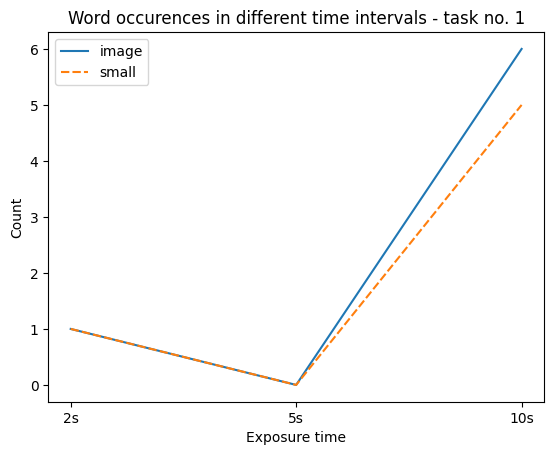

Task 2, word "contact", p = 0.036600539154270924
Task 2, word "lens", p = 0.04978706836786395
Task 2, word "glass", p = 0.013123728736940971


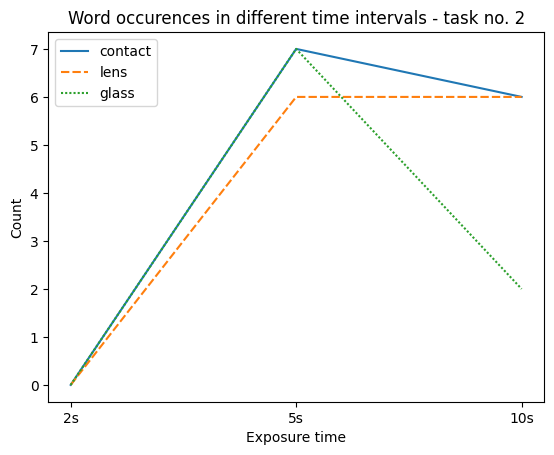

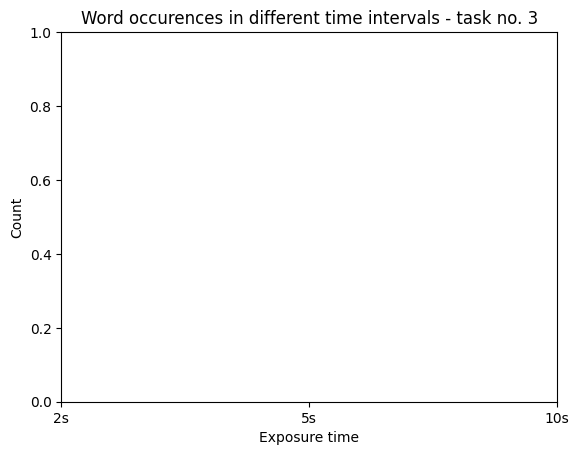

Task 4, word "blue", p = 0.0439369336234074
Task 4, word "hand", p = 0.006737946999085476
Task 4, word "rain", p = 0.018315638888734168


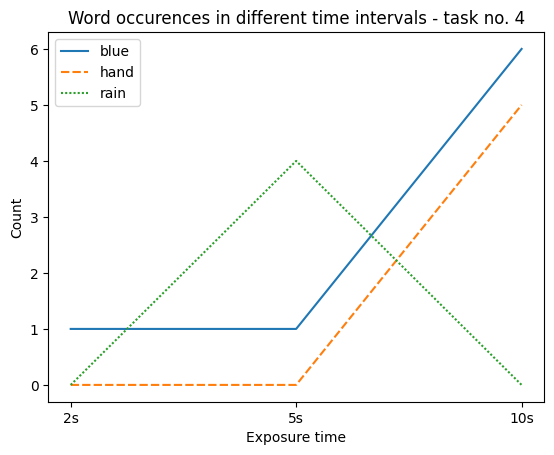

Task 5, word "animal", p = 0.02472352647033942


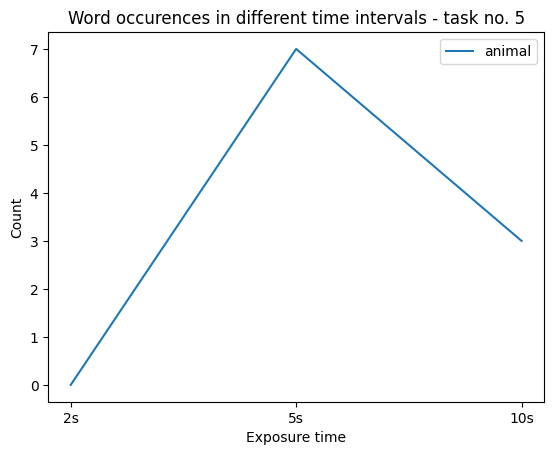

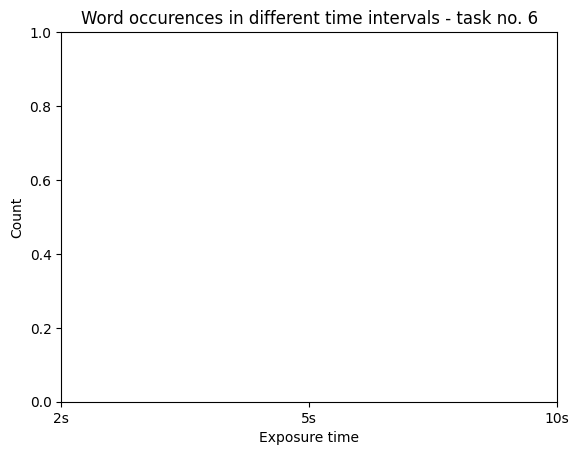










med


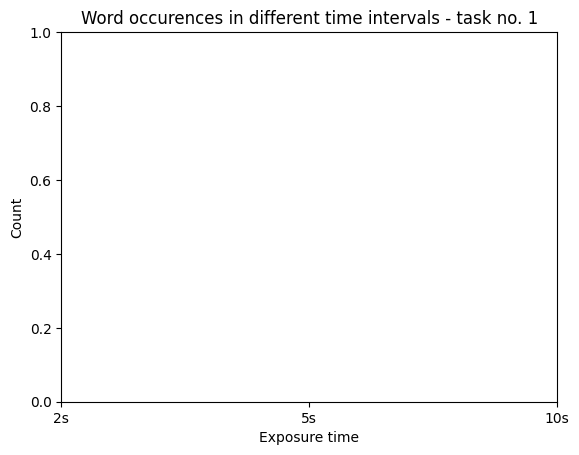

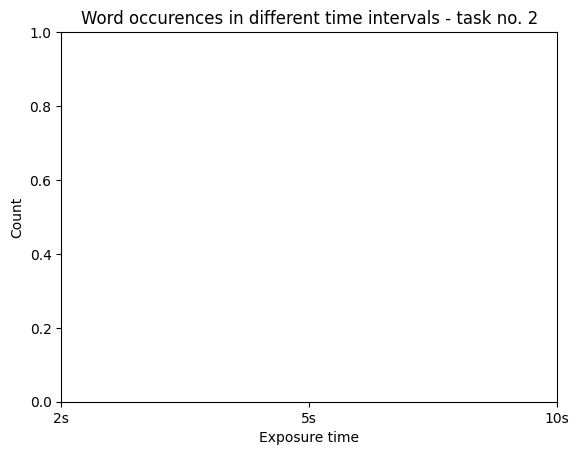

Task 3, word "top", p = 0.007446583070924346


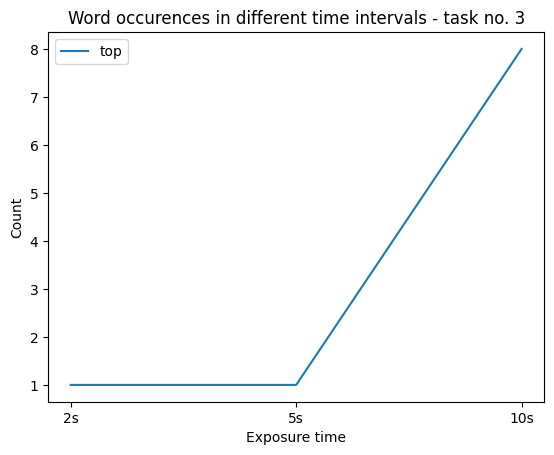

Task 4, word "prague", p = 4.539992976248493e-05
Task 4, word "showing", p = 0.030197383422318487


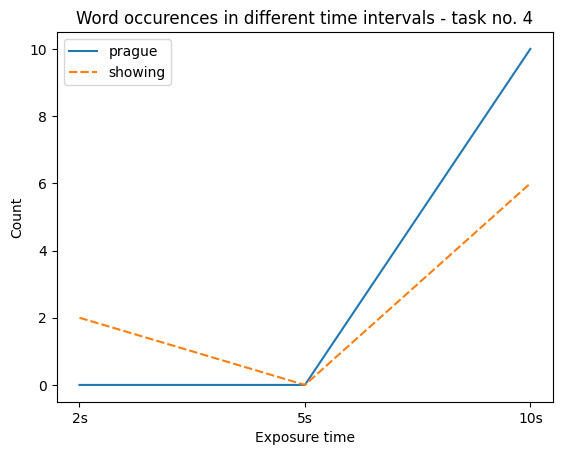

Task 5, word "yellow", p = 0.03877420783172202
Task 5, word "website", p = 0.03460917828870049


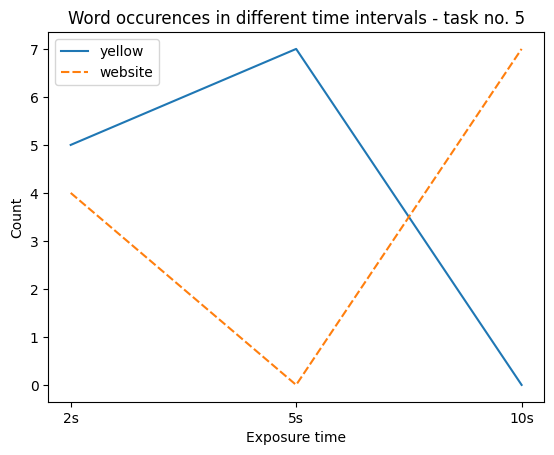

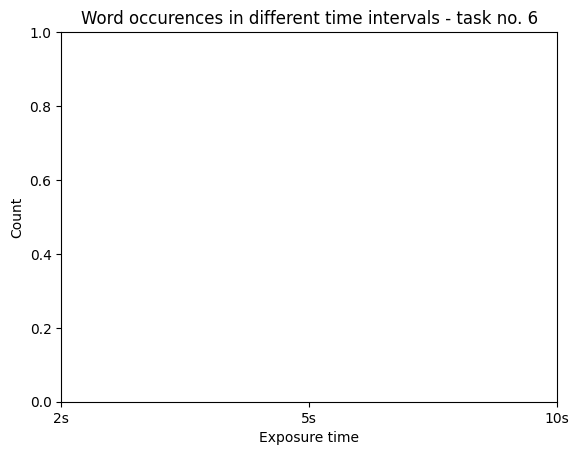










high


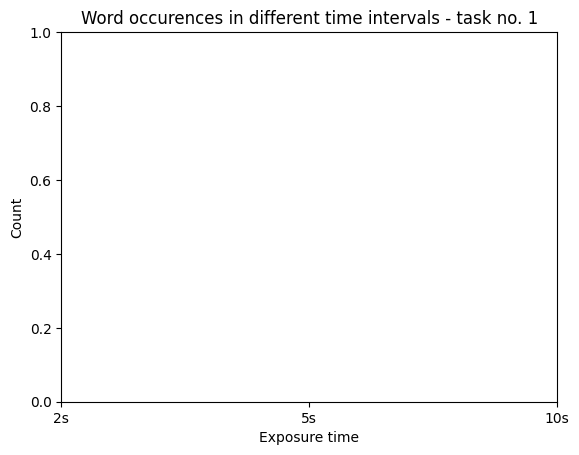

Task 2, word "glass", p = 0.03877420783172202


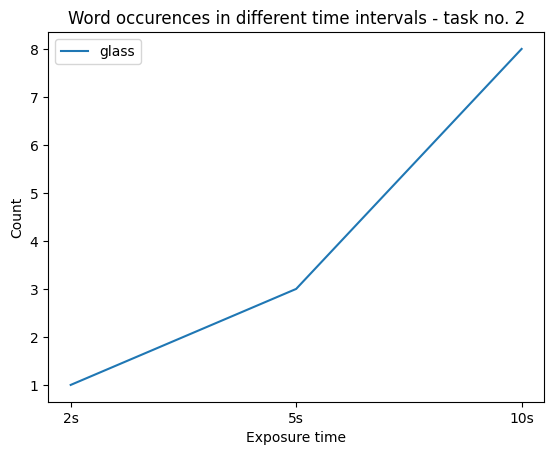

Task 3, word "image", p = 0.04504920239355782
Task 3, word "big", p = 0.013123728736940971
Task 3, word "section", p = 0.030197383422318487
Task 3, word "website", p = 0.011931522535756139


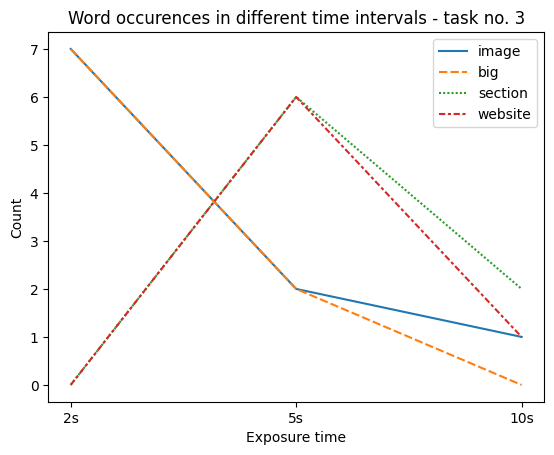

Task 4, word "information", p = 0.030197383422318508
Task 4, word "blue", p = 0.04504920239355782


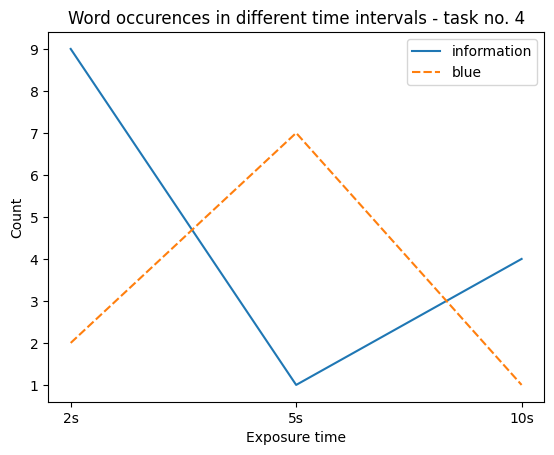

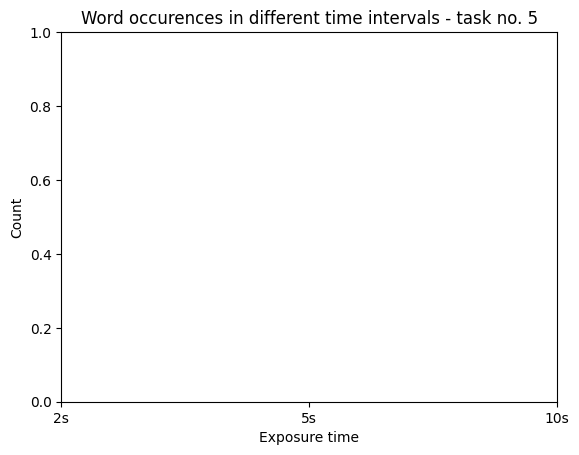

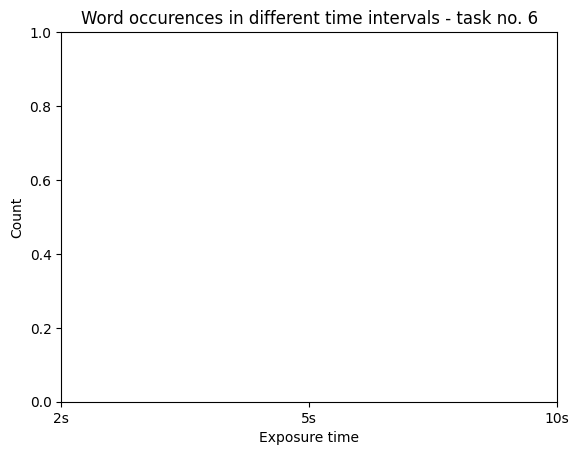

In [66]:
texts = {
    1: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    2: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    3: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    4: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    5: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    6: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
}

for index, row in data.iterrows():
    texts[row.task][row.interval][row.vmt_levels_group] += (row.desc_tokens + ' ') if type(row.desc_tokens) == str else ''

for group in ['low', 'med', 'high']:
    word_differences = {
    1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
    }
    significant_words = {
        1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
    }
    print('\n\n\n\n\n\n\n\n\n' + group)
    for task in [1, 2, 3, 4, 5, 6]:
        words = texts[task]['2s'][group] + texts[task]['5s'][group] + texts[task]['10s'][group]
        words_2s = sorted(WordCloud(collocations=False).process_text(texts[task]['2s'][group]).items(),key=lambda item: -item[1])    
        words_5s = sorted(WordCloud(collocations=False).process_text(texts[task]['5s'][group]).items(),key=lambda item: -item[1])    
        words_10s = sorted(WordCloud(collocations=False).process_text(texts[task]['10s'][group]).items(),key=lambda item: -item[1])
        most_common_words = list(map(lambda x: x[0], sorted(WordCloud(collocations=False).process_text(words).items(),key=lambda item: -item[1])[0:15]))
        for word in most_common_words:
            word_differences[task][word] = [
                words_2s[[x[0] for x in words_2s].index(word)][1] if word in [x[0] for x in words_2s] else 0,
                words_5s[[x[0] for x in words_5s].index(word)][1] if word in [x[0] for x in words_5s] else 0,
                words_10s[[x[0] for x in words_10s].index(word)][1] if word in [x[0] for x in words_10s] else 0
            ]
            stat = stats.chisquare(word_differences[task][word])
            if(stat.pvalue < 0.05):
                significant_words[task][word] = word_differences[task][word]
                print('Task ' + str(task) + ', word "' + word + '", p = ' + str(stat.pvalue))
        fig = sns.lineplot(data=significant_words[task])
        fig.set_xticks([0, 1, 2])
        fig.set_xticklabels(['2s','5s','10s'])
        fig.set_title('Word occurences in different time intervals - task no. ' + str(task))
        fig.set_xlabel('Exposure time')
        fig.set_ylabel('Count')
        plt.show()










low


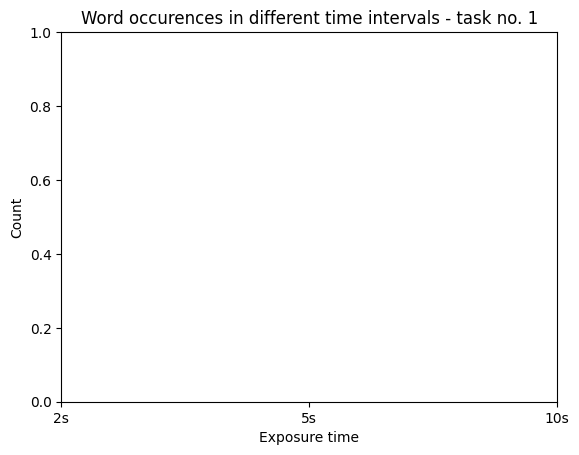

Task 2, word "family", p = 0.022370771856165598
Task 2, word "page", p = 0.030197383422318487
Task 2, word "top", p = 0.011931522535756151


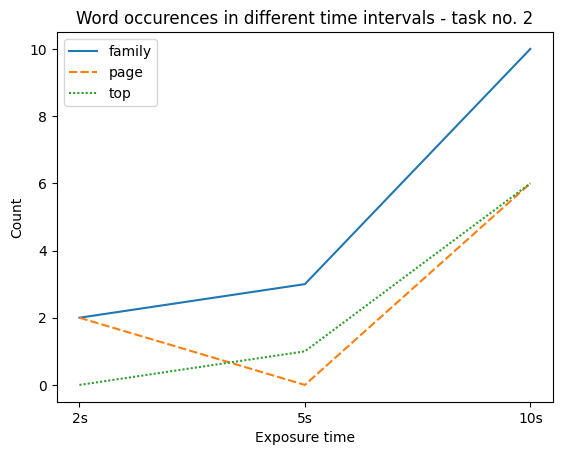

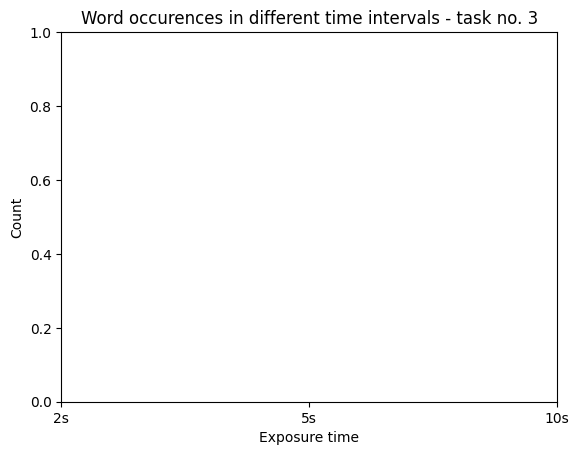

Task 4, word "different", p = 0.030197383422318487


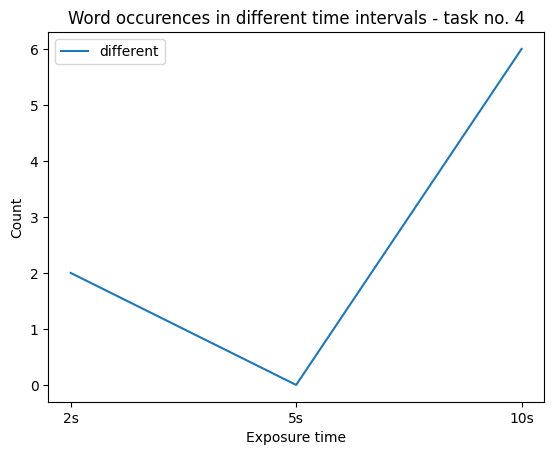

Task 5, word "lot", p = 0.0301973834223185


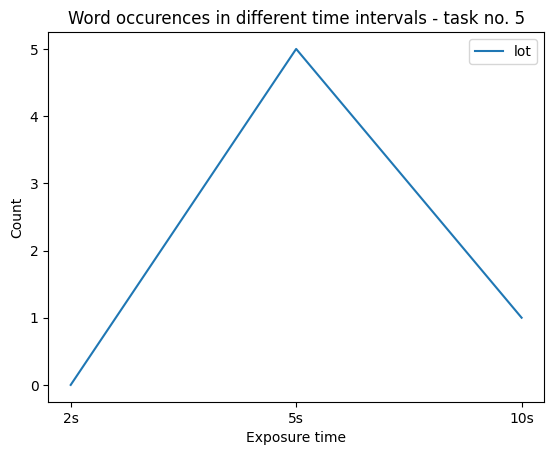

Task 6, word "news", p = 0.019425347946439436


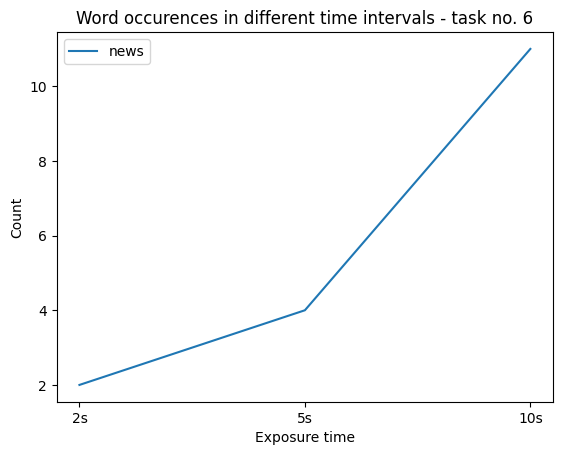










med
Task 1, word "image", p = 0.02472352647033942


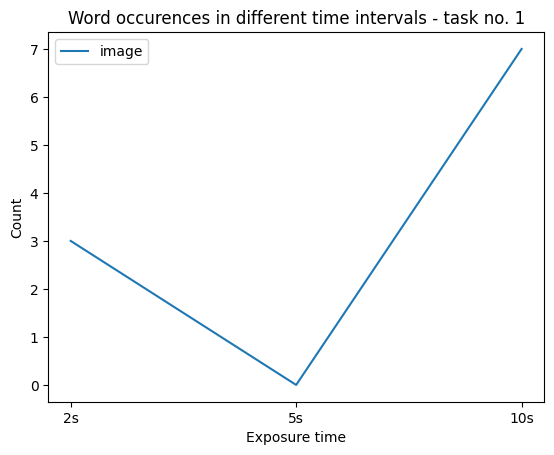

Task 2, word "blue", p = 0.03877420783172202
Task 2, word "website", p = 0.04504920239355782


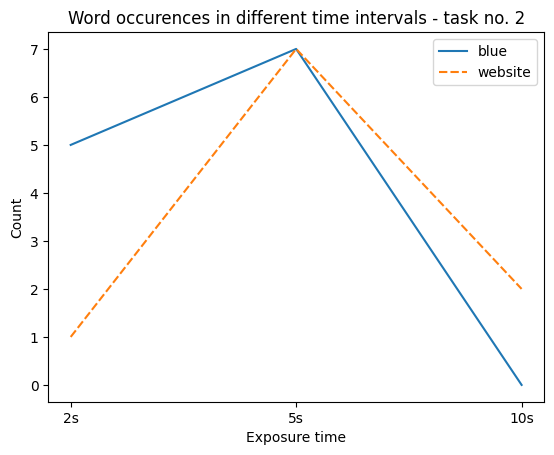

Task 3, word "image", p = 0.0421438435092764
Task 3, word "website", p = 0.004389361842778439
Task 3, word "mountain", p = 0.030197383422318487


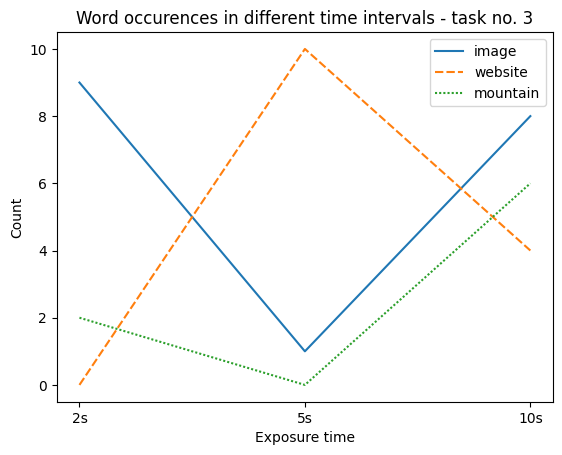

Task 4, word "website", p = 0.007446583070924351


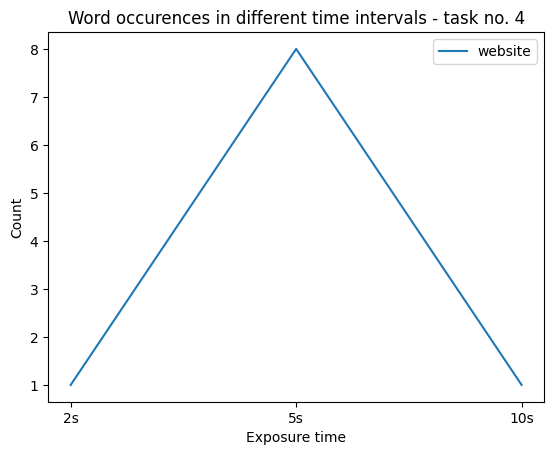

Task 5, word "item", p = 0.011931522535756151


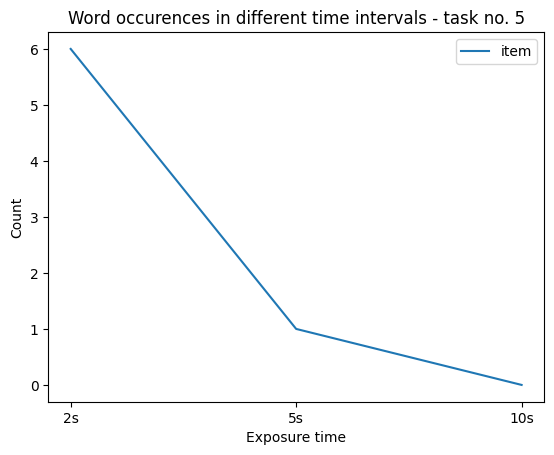

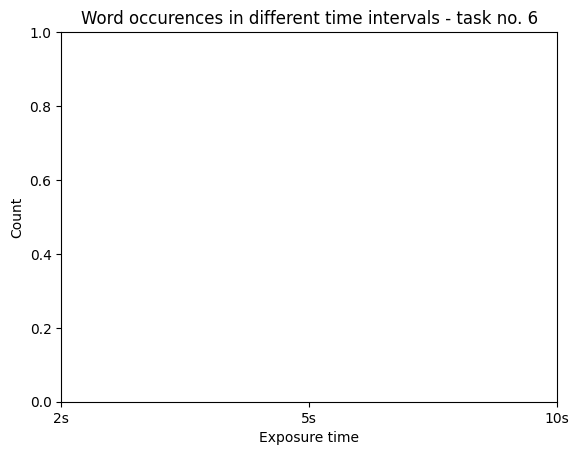










high
Task 1, word "woman", p = 0.04978706836786395
Task 1, word "clothing", p = 0.015503853599009307


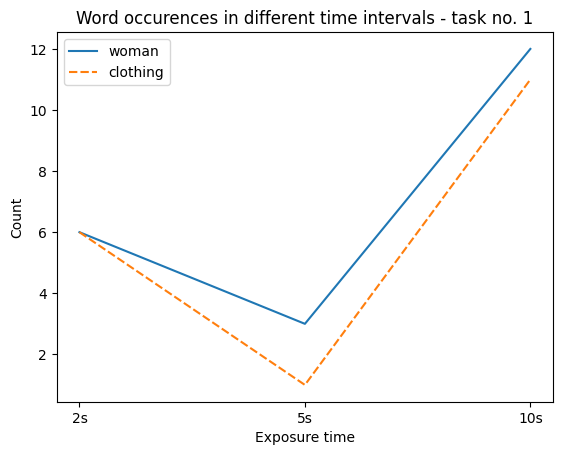

Task 2, word "picture", p = 0.027647076357758687


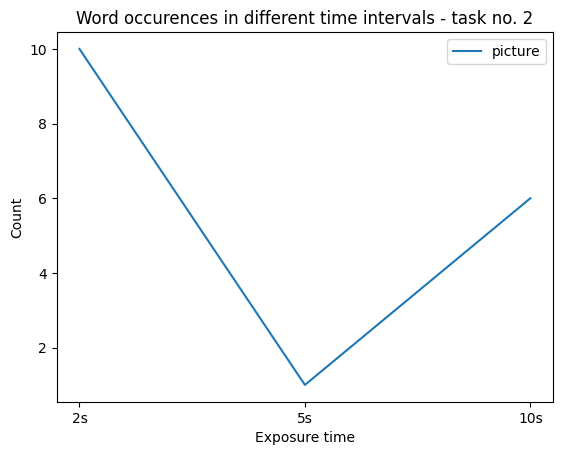

Task 3, word "white", p = 0.030197383422318487


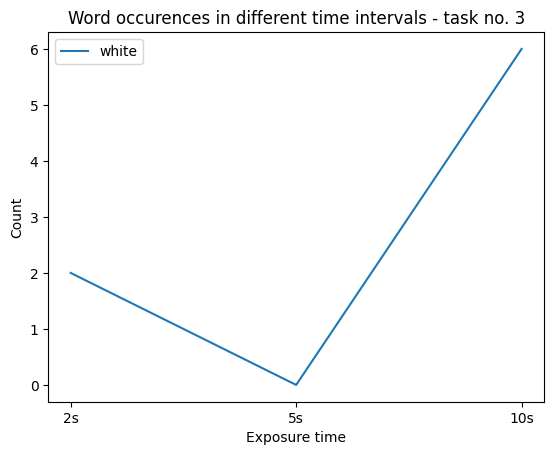

Task 4, word "prague", p = 0.005516564420760776
Task 4, word "showing", p = 0.0301973834223185
Task 4, word "lot", p = 0.006737946999085476


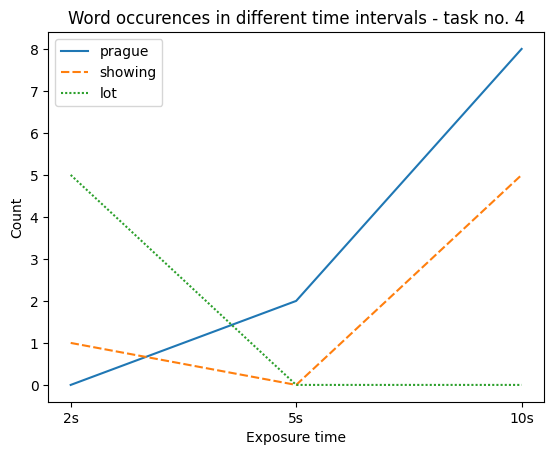

Task 5, word "different", p = 0.02472352647033942


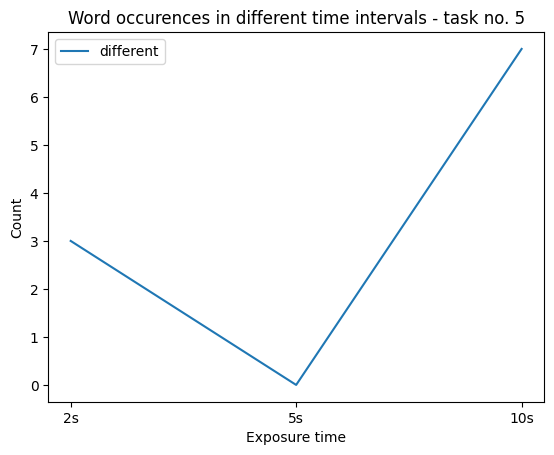

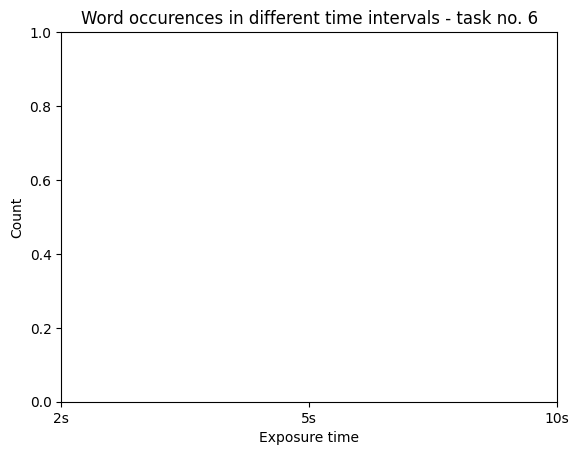

In [67]:
texts = {
    1: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    2: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    3: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    4: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    5: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
    6: {'2s': {'low': '', 'med': '', 'high': ''}, '5s': {'low': '', 'med': '', 'high': ''}, '10s': {'low': '', 'med': '', 'high': ''}},
}

for index, row in data.iterrows():
    texts[row.task][row.interval][row.pst_levels_correct_group] += (row.desc_tokens + ' ') if type(row.desc_tokens) == str else ''

for group in ['low', 'med', 'high']:
    word_differences = {
    1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
    }
    significant_words = {
        1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
    }
    print('\n\n\n\n\n\n\n\n\n' + group)
    for task in [1, 2, 3, 4, 5, 6]:
        words = texts[task]['2s'][group] + texts[task]['5s'][group] + texts[task]['10s'][group]
        words_2s = sorted(WordCloud(collocations=False).process_text(texts[task]['2s'][group]).items(),key=lambda item: -item[1])    
        words_5s = sorted(WordCloud(collocations=False).process_text(texts[task]['5s'][group]).items(),key=lambda item: -item[1])    
        words_10s = sorted(WordCloud(collocations=False).process_text(texts[task]['10s'][group]).items(),key=lambda item: -item[1])
        most_common_words = list(map(lambda x: x[0], sorted(WordCloud(collocations=False).process_text(words).items(),key=lambda item: -item[1])[0:15]))
        for word in most_common_words:
            word_differences[task][word] = [
                words_2s[[x[0] for x in words_2s].index(word)][1] if word in [x[0] for x in words_2s] else 0,
                words_5s[[x[0] for x in words_5s].index(word)][1] if word in [x[0] for x in words_5s] else 0,
                words_10s[[x[0] for x in words_10s].index(word)][1] if word in [x[0] for x in words_10s] else 0
            ]
            stat = stats.chisquare(word_differences[task][word])
            if(stat.pvalue < 0.05):
                significant_words[task][word] = word_differences[task][word]
                print('Task ' + str(task) + ', word "' + word + '", p = ' + str(stat.pvalue))
        fig = sns.lineplot(data=significant_words[task])
        fig.set_xticks([0, 1, 2])
        fig.set_xticklabels(['2s','5s','10s'])
        fig.set_title('Word occurences in different time intervals - task no. ' + str(task))
        fig.set_xlabel('Exposure time')
        fig.set_ylabel('Count')
        plt.show()